# ECG Processing

In [55]:
#import libraries


import numpy as np
import pandas as pd
import os
import scipy

from tqdm import tqdm as tqdm
from scipy.signal import butter, filtfilt, iirnotch, find_peaks

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm


In [60]:
# --- 1. GLOBAL STYLE CONFIGURATION ---

# Set Resolution to 300 DPI for presentation quality
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

# Set Font to Manrope
# Note: 'Manrope' must be installed on your OS. 
# If not found, it will fall back to the default sans-serif font (e.g., Arial/DejaVu).
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Times New Roman']

# Improve Font Readability for Slides
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

# Helper to check if Manrope is detected (Optional check)
found = any(f.name == 'Times New Roman' for f in fm.fontManager.ttflist)
print(f"Times New Roman font detected: {found}")

Times New Roman font detected: True


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
# # Set your own specific drive path
ROOT_PATH   = os.path.dirname(os.getcwd())
DATA_FOLDER   = os.path.join(ROOT_PATH, "Data")
DATA_Batch_01 = os.path.join(DATA_FOLDER, "01_batch_ECG_Signals")
DATA_Batch_02 = os.path.join(DATA_FOLDER, "02_batch_ECG_Signals")

In [24]:
# prepare functions for filtering
# basic ECG preprocessing

def butter_bandpass(lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def apply_bandpass_filter(data, lowcut=1, highcut=40, fs=1000, order=2):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    return filtfilt(b, a, data, axis=0)

def notch_filter(data, freq=50, fs=1000, quality_factor=30):
    b, a = iirnotch(freq / (fs / 2), quality_factor)
    return filtfilt(b, a, data, axis=0)

In [ ]:
# normalization function
def apply_normalization(data):
    """
    Applies Z-score normalization (Standardization) per lead.
    Formula: (x - mean) / std
    """
    # Calculate mean and std along the time axis (axis 0)
    mu = np.mean(data, axis=0)
    sigma = np.std(data, axis=0)
    
    # Avoid division by zero by adding a small epsilon
    epsilon = 1e-8
    return (data - mu) / (sigma + epsilon)

In [34]:
#import the data and filter the signals
# This could be change depending if you download or not the data

#ECG_folder = "/content/drive/MyDrive/WP_02_data/1_batch_extracted"
#ECG_folder_2batch = "/content/drive/MyDrive/WP_02_data/2_batch_extracted"

filename_Batch_01     = f"{DATA_FOLDER}\\VALETUDO_database_1st_batch_en_all_info.xlsx"
filename_Batch_02     = f"{DATA_FOLDER}\\VALETUDO_database_2nd_batch_en_all_info.xlsx"
tabular_data_Batch_01 = pd.read_excel(filename_Batch_01)
tabular_data_Batch_02 = pd.read_excel(filename_Batch_02)

# --- Load and filter both batches ---
ECGs_1 = [f for f in os.listdir(DATA_Batch_01) if f.endswith(".mat")]
ECGs_2 = [f for f in os.listdir(DATA_Batch_02) if f.endswith(".mat")]

def extract_patient_id(filename):
    return int(filename.split(".")[0])

ECGs_1.sort(key=extract_patient_id)
ECGs_2.sort(key=extract_patient_id)

signals_1 = np.empty((len(ECGs_1), 5000, 12))
signals_2 = np.empty((len(ECGs_2), 5000, 12))

for index, ecg_path in enumerate(ECGs_1):
    filepath = os.path.join(DATA_Batch_01, ecg_path)
    matdata = scipy.io.loadmat(filepath)
    ecg = matdata['val']
    # for i in range(12):
    #     ecg[:, i] = ecg[:, i] - np.mean(ecg[:, i])
    #     ecg[:, i] = apply_bandpass_filter(ecg[:, i])
    #     ecg[:, i] = notch_filter(ecg[:, i])
    signals_1[index, :, :] = ecg

for index, ecg_path in enumerate(ECGs_2):
    filepath = os.path.join(DATA_Batch_02, ecg_path)
    matdata = scipy.io.loadmat(filepath)
    ecg = matdata['val']
    # for i in range(12):
    #     ecg[:, i] = ecg[:, i] - np.mean(ecg[:, i])
    #     ecg[:, i] = apply_bandpass_filter(ecg[:, i])
    #     ecg[:, i] = notch_filter(ecg[:, i])
    signals_2[index, :, :] = ecg

# --- Concatenate signals and tabular data ---
signals = np.concatenate([signals_1, signals_2], axis=0)
tabular_data = pd.concat([
    tabular_data_Batch_01.sort_values(by="ECG_patient_id").reset_index(drop=True),
    tabular_data_Batch_02.sort_values(by="ECG_patient_id").reset_index(drop=True)
], ignore_index=True)

print("Combined signals shape:", signals.shape)
print("Combined tabular shape:", tabular_data.shape)



Combined signals shape: (526, 5000, 12)
Combined tabular shape: (526, 19)


In [35]:
print(f"nb pos: {np.sum(tabular_data_Batch_01['sport_ability']==1)}")
print(f"% pos: {np.sum(tabular_data_Batch_01['sport_ability']==1)/len(tabular_data_Batch_01['sport_ability'])*100:.2f}%")

nb pos: 107
% pos: 56.02%


In [36]:
tabular_data_Batch_01

code  ECG_patient_id  age_at_exam  sex  weight  height  trainning_load  \
0       1               3    20.095825    0    60.0   166.0               2   
1       2               4    51.646817    0    84.0   180.0               2   
2       3               5    40.936345    0   104.0   180.0               1   
3       4               6    14.201232    0    80.0   174.0               2   
4       5               7    16.607803    1    47.0   148.0               2   
..    ...             ...          ...  ...     ...     ...             ...   
186   187             210    22.228611    0    73.0   185.0               2   
187   188             211    18.190281    0    60.0   172.0               2   
188   189             212    50.332649    1    70.0   168.0               1   
189   190             213    27.646817    1    50.0   159.0               2   
190   191             214    19.080082    1    58.0   158.0               2   

     sport_classification  sport_ability  AV block  ST abnormality  \
0                       1              0         0               0   
1                       1              0         0               1   
2                       1              0         0               0   
3                       1              1         0               0   
4                       1              0         0               1   
..                    ...            ...       ...             ...   
186                     1              1         0               0   
187                     1              1         0               0   
188                     0              1         0               0   
189                     1              1         0               0   
190                     1              1         0               0   

     Complete BBB  Prolonged QTc  Uncontrolled hypertension  \
0               0              0                          0   
1               0              0                          1   
2               0              0                          0   
3               0              0                          0   
4               0              0                          0   
..            ...            ...                        ...   
186             0              0                          0   
187             0              0                          0   
188             0              0                          0   
189             0              0                          0   
190             0              0                          0   

     Supraventricular arrhythmias  Ventricular arrhythmias  \
0                               0                        1   
1                               0                        0   
2                               0                        1   
3                               0                        0   
4                               0                        0   
..                            ...                      ...   
186                             0                        0   
187                             0                        0   
188                             0                        0   
189                             0                        0   
190                             0                        0   

     Baseline ECG abnormalities  Valvular heart diseases  Symptomatic patients  
0                             0                        0                     0  
1                             0                        0                     0  
2                             0                        0                     0  
3                             0                        0                     0  
4                             1                        0                     0  
..                          ...                      ...                   ...  
186                           0                        0                     0  
187                           0                        0         

27.846692505201773


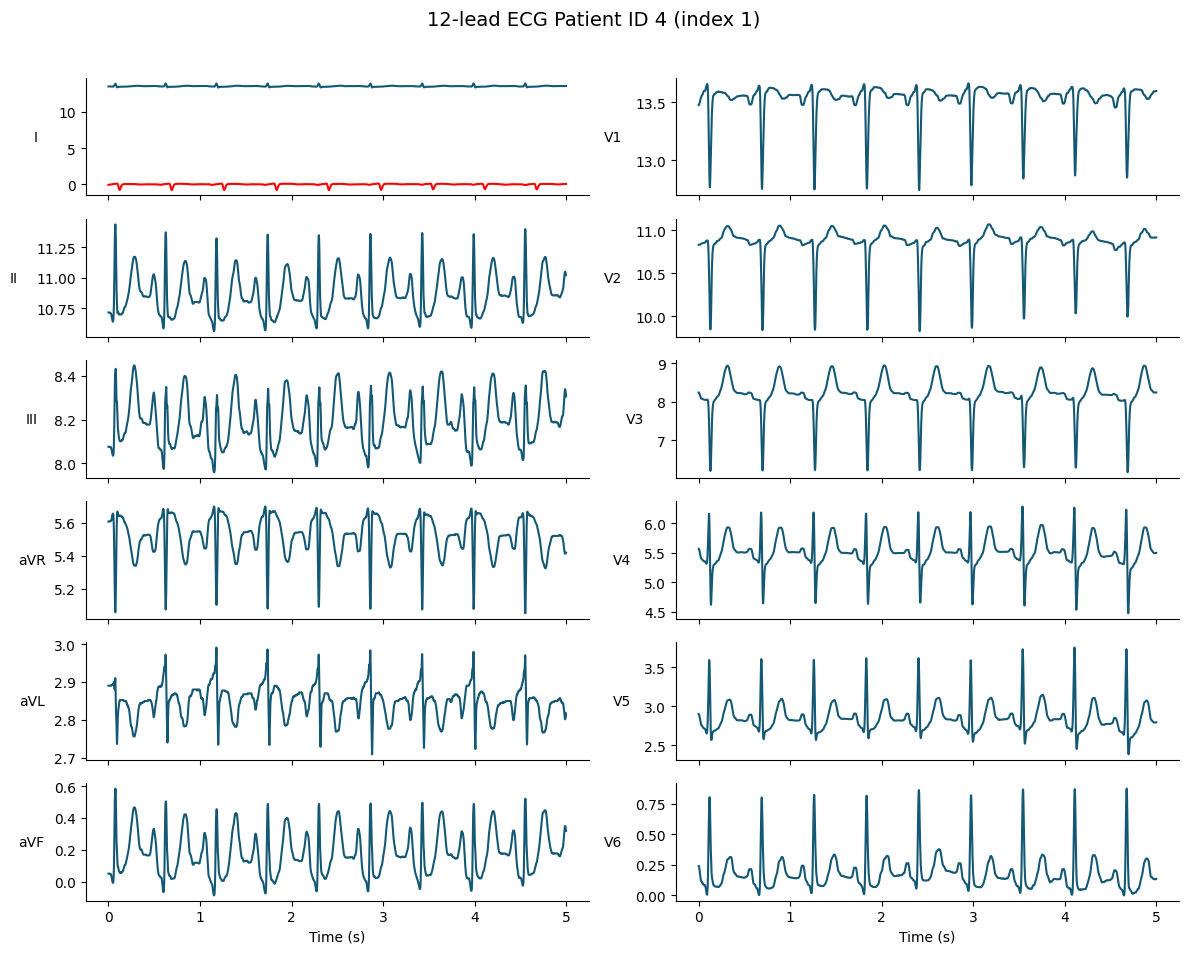

In [37]:
def plot_12lead_for_patient(patient_id, signals, tabular_data, fs=500):
    """
    Plot 12-lead ECG for given patient_id using the already-merged `signals` array.
    Arrange leads so that limb leads (I, II, III, aVR, aVL, aVF) are in the first column
    and precordial leads (V1..V6) are in the second column.
    """
    # find index in tabular_data
    idx_list = tabular_data.index[tabular_data['ECG_patient_id'] == patient_id].tolist()
    if len(idx_list) == 0:
        raise ValueError(f"Patient id {patient_id} not found in tabular_data['ECG_patient_id'].")
    idx = int(idx_list[0])

    if idx < 0 or idx >= signals.shape[0]:
        raise IndexError(f"Found index {idx} out of range for signals (shape {signals.shape}).")

    sig = signals[idx]  # shape (n_samples, 12)
    if sig.ndim != 2 or sig.shape[1] != 12:
        raise ValueError(f"Expected signal shape (n_samples, 12), got {sig.shape}")

    n_samples = sig.shape[0]
    t = np.arange(n_samples) / fs  # seconds; change to ms if desired by multiplying by 1000

    # desired layout:
    # column 0: I, II, III, aVR, aVL, aVF
    # column 1: V1, V2, V3, V4, V5, V6
    lead_names = ['I','II','III','aVR','aVL','aVF','V1','V2','V3','V4','V5','V6']

    # mapping lead index -> (row, col) in 6x2 grid
    mapping = {
        0: (0, 0),  # I
        1: (1, 0),  # II
        2: (2, 0),  # III
        3: (3, 0),  # aVR
        4: (4, 0),  # aVL
        5: (5, 0),  # aVF
        6: (0, 1),  # V1
        7: (1, 1),  # V2
        8: (2, 1),  # V3
        9: (3, 1),  # V4
        10: (4, 1), # V5
        11: (5, 1)  # V6
    }

    # vertical offsets for visualization
    amp = np.max(np.abs(sig)) if np.max(np.abs(sig)) > 0 else 1.0
    offset = 2 * amp
    print(offset)

    fig, axes = plt.subplots(6, 2, figsize=(12, 10), sharex=True)
    for lead_idx in range(12):
        r, c = mapping[lead_idx]
        ax = axes[r, c]
        ax.plot(t, sig[:, lead_idx], color='#155874')
        ax.set_ylabel(lead_names[lead_idx], rotation=0, labelpad=16, va='center')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    ax = axes[0, 0]
    sig_plot = sig[:, 6] + 6 * offset
    sig_plot = sig_plot - sig_plot.mean(axis=0, keepdims=True)
    ax.plot(t, sig_plot, color='red')

    # remove empty spines/labels for clarity
    for r in range(6):
        for c in range(2):
            axes[r, c].tick_params(axis='y', which='both', left=True)
    axes[-1, 0].set_xlabel('Time (s)')
    axes[-1, 1].set_xlabel('Time (s)')

    fig.suptitle(f'12-lead ECG Patient ID {patient_id} (index {idx})', fontsize=14)
    plt.tight_layout(rect=[0, 0.03, 1, 0.96])
    plt.show()

# Example: plot patient with id 4
plot_12lead_for_patient(4, signals, tabular_data_Batch_01, fs=1000)

In [40]:
# def align_ecg_rpeak(ecg_matrix, fs=1000):
#     """
#     Aligns Precordial leads (idx 6-11) to Limb leads (idx 0-5) using R-peak matching.
#     Input: (5000, 12) array
#     """
#     # 1. Select Anchor Leads
#     # Lead II (index 1) is the standard reference for Limb leads.
#     # Lead V5 (index 10) usually has a strong R-wave similar to Lead II.
#     ref_sig = ecg_matrix[:, 1]  # Limb Reference
#     mov_sig = ecg_matrix[:, 10] # Precordial Target (to be moved)

#     # 2. Normalize for Detection (Z-score to handle amplitude differences)
#     # We add 1e-6 to avoid division by zero
#     ref_norm = (ref_sig - np.mean(ref_sig)) / (np.std(ref_sig) + 1e-6)
#     mov_norm = (mov_sig - np.mean(mov_sig)) / (np.std(mov_sig) + 1e-6)

#     # 3. Peak Detection
#     # Distance = 200ms (0.2 * fs) to avoid detecting T-waves or noise
#     peaks_ref, _ = find_peaks(ref_norm, height=1.0, distance=int(0.2 * fs))
#     peaks_mov, _ = find_peaks(mov_norm, height=1.0, distance=int(0.2 * fs))

#     # Safety Check: If peaks aren't found, return original
#     if len(peaks_ref) == 0 or len(peaks_mov) == 0:
#         return ecg_matrix, 0

#     # 4. Calculate Lag
#     # We take the first peak in the Limb leads as the anchor point
#     first_ref_peak = peaks_ref[0]

#     # Find the peak in Precordial leads that is CLOSEST to that anchor point
#     # This prevents aligning to the wrong beat if the lag is small
#     idx_nearest = np.argmin(np.abs(peaks_mov - first_ref_peak))
#     nearest_mov_peak = peaks_mov[idx_nearest]

#     lag = nearest_mov_peak - first_ref_peak

#     # 5. Shift and Pad
#     aligned_matrix = ecg_matrix.copy()
#     precordial_indices = range(6, 12) # Indices for V1-V6

#     if lag > 0:
#         # Precordial is "late" (shifted right). We must shift LEFT.
#         # Crop the start, pad the end with zeros.
#         for i in precordial_indices:
#             aligned_matrix[:, i] = np.pad(ecg_matrix[lag:, i], (0, lag), 'constant')
            
#     elif lag < 0:
#         # Precordial is "early". We must shift RIGHT.
#         # Pad the start with zeros, crop the end.
#         shift = abs(lag)
#         for i in precordial_indices:
#             aligned_matrix[:, i] = np.pad(ecg_matrix[:-shift, i], (shift, 0), 'constant')

#     return aligned_matrix, lag

# # --- Apply to the whole dataset ---
# aligned_signals = np.empty_like(signals)
# alignment_lags = []

# for i in range(len(signals)):
#     aligned_signals[i], lag = align_ecg_rpeak(signals[i], fs=1000)
#     alignment_lags.append(lag)

# print(f"Alignment complete. Average absolute lag: {np.mean(np.abs(alignment_lags)):.2f} samples")

In [41]:
# plot_12lead_for_patient(4, aligned_signals, tabular_data_Batch_01, fs=1000)

In [42]:
def preprocess_ecg_batch(signals, fs=1000):
    """
    Args:
        signals: np.array of shape (N_subjects, 5000, 12)
        fs: Sampling frequency (default 1000 Hz)
    Returns:
        processed_signals: np.array of same shape
    """
    processed_signals = np.empty_like(signals)
    
    print(f"Starting preprocessing for {len(signals)} subjects...")
    
    for i, patient_ecg in tqdm(enumerate(signals)):
        # patient_ecg shape is (5000, 12)
        
        # 1. Bandpass Filter (0.5-40 Hz as per your config)
        # Note: 1Hz lowcut is aggressive and may attenuate ST changes. 
        # 0.5Hz is safer for clinical ischemia detection, but 1Hz is cleaner for noise.
        filtered = apply_bandpass_filter(patient_ecg, lowcut=0.5, highcut=40, fs=fs)
        
        # 2. Notch Filter (50 Hz)
        filtered = notch_filter(filtered, freq=50, fs=fs)
        
        # 3. Normalization (Z-score)
        normalized = apply_normalization(filtered)
        
        processed_signals[i] = normalized
        
    print("Preprocessing complete.")
    return processed_signals

In [43]:
signals_clean = preprocess_ecg_batch(signals, fs=1000)

Starting preprocessing for 526 subjects...


526it [00:03, 158.28it/s]

Preprocessing complete.


10.63190192909222


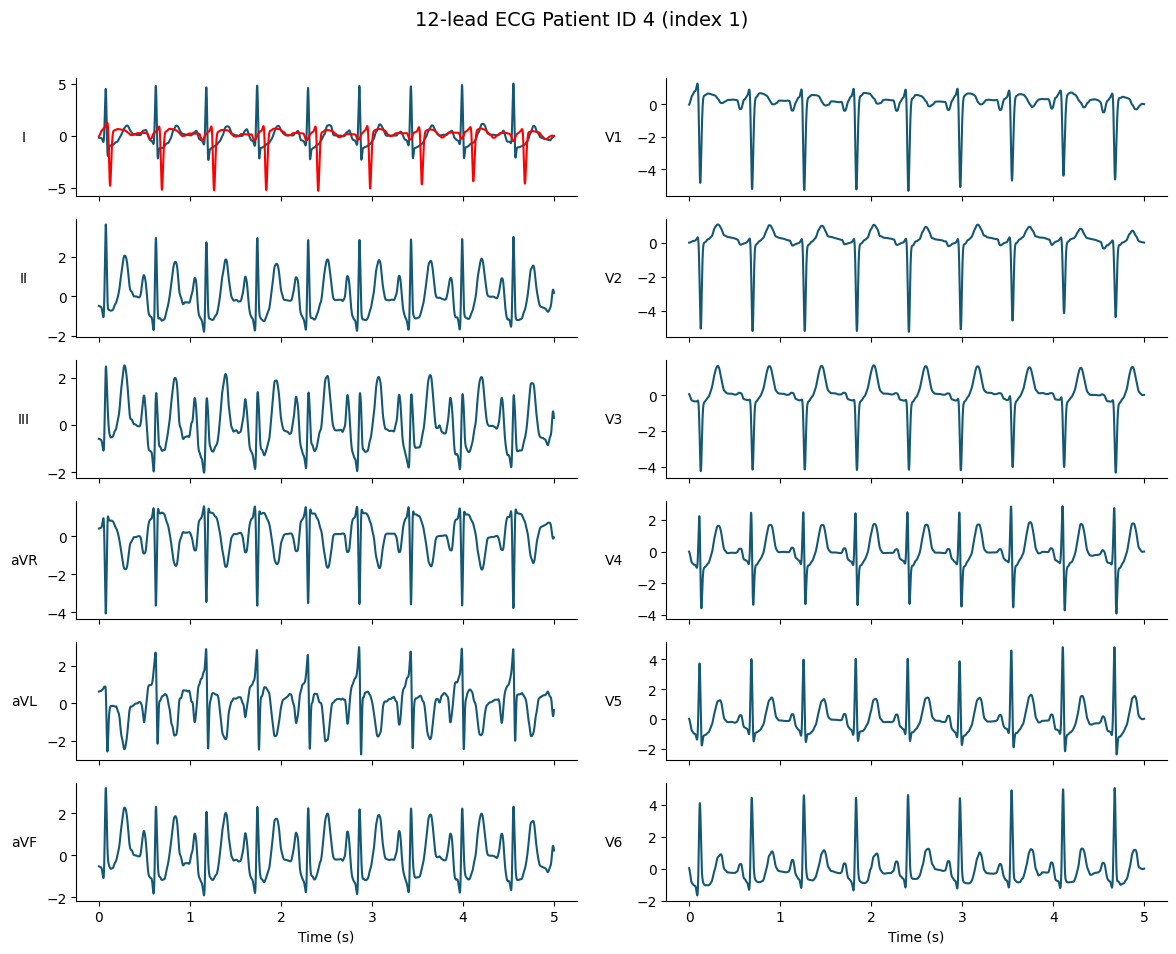

In [44]:
plot_12lead_for_patient(4, signals_clean, tabular_data_Batch_01, fs=1000)

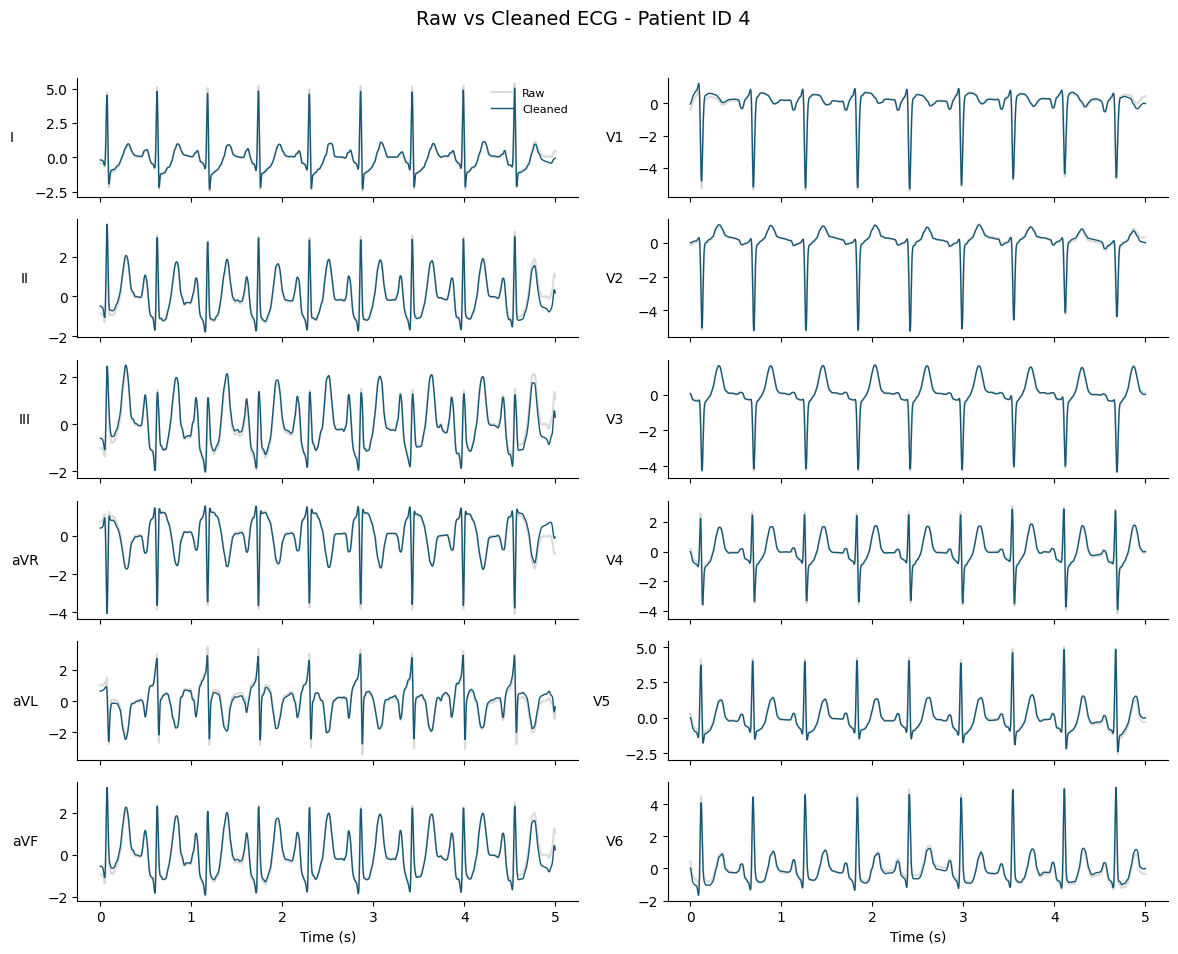

In [ ]:
def plot_comparison_for_patient(patient_id, signals_raw, signals_clean, tabular_data, fs=1000):
    """
    Plot comparison of Raw vs Cleaned 12-lead ECG for given patient_id WITHOUT temporary normalization.
    Arrange leads so that limb leads (I, II, III, aVR, aVL, aVF) are in the first column
    and precordial leads (V1..V6) are in the second column.
    """
    # find index in tabular_data
    idx_list = tabular_data.index[tabular_data['ECG_patient_id'] == patient_id].tolist()
    if len(idx_list) == 0:
        raise ValueError(f"Patient id {patient_id} not found in tabular_data['ECG_patient_id'].")
    idx = int(idx_list[0])

    if idx < 0 or idx >= signals_raw.shape[0]:
        raise IndexError(f"Found index {idx} out of range for signals (shape {signals_raw.shape}).")

    sig_raw = signals_raw[idx]    # shape (n_samples, 12)
    sig_clean = signals_clean[idx] # shape (n_samples, 12)

    if sig_raw.ndim != 2 or sig_raw.shape[1] != 12:
        raise ValueError(f"Expected signal shape (n_samples, 12), got {sig_raw.shape}")

    n_samples = sig_raw.shape[0]
    t = np.arange(n_samples) / fs  # seconds

    # desired layout:
    # column 0: I, II, III, aVR, aVL, aVF
    # column 1: V1, V2, V3, V4, V5, V6
    lead_names = ['I','II','III','aVR','aVL','aVF','V1','V2','V3','V4','V5','V6']

    # mapping lead index -> (row, col) in 6x2 grid
    mapping = {
        0: (0, 0),  # I
        1: (1, 0),  # II
        2: (2, 0),  # III
        3: (3, 0),  # aVR
        4: (4, 0),  # aVL
        5: (5, 0),  # aVF
        6: (0, 1),  # V1
        7: (1, 1),  # V2
        8: (2, 1),  # V3
        9: (3, 1),  # V4
        10: (4, 1), # V5
        11: (5, 1)  # V6
    }

    fig, axes = plt.subplots(6, 2, figsize=(12, 10), sharex=True)
    
    for lead_idx in range(12):
        r, c = mapping[lead_idx]
        ax = axes[r, c]
        
        # We assume signals_clean is already Z-scored. We apply Z-score to raw just for the plot.
        raw_trace = sig_raw[:, lead_idx]
        raw_vis = (raw_trace - np.mean(raw_trace)) / (np.std(raw_trace) + 1e-8)

        ax.plot(t, raw_vis, color='lightgrey', label='Raw', linewidth=1.5, alpha=0.8)
        
        # Plot Cleaned (Foreground, Your Style Color)
        ax.plot(t, sig_clean[:, lead_idx], color='#155874', label='Cleaned', linewidth=1.0)
        
        ax.set_ylabel(lead_names[lead_idx], rotation=0, labelpad=16, va='center')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        # Add legend only to the first subplot to avoid clutter
        if lead_idx == 0:
            ax.legend(loc='upper right', frameon=False, fontsize=8)

    # remove empty spines/labels for clarity
    for r in range(6):
        for c in range(2):
            axes[r, c].tick_params(axis='y', which='both', left=True)
            
    axes[-1, 0].set_xlabel('Time (s)')
    axes[-1, 1].set_xlabel('Time (s)')

    fig.suptitle(f'Raw vs Cleaned ECG - Patient ID {patient_id}', fontsize=14)
    plt.tight_layout(rect=[0, 0.03, 1, 0.96])
    plt.show()

# --- Usage Example ---
# Assuming 'signals' is your raw data and 'signals_clean' is the output of preprocess_ecg_batch
plot_comparison_for_patient(4, signals, signals_clean, tabular_data_Batch_01, fs=1000)

--- RAW ECG Signals for Patient 4 ---


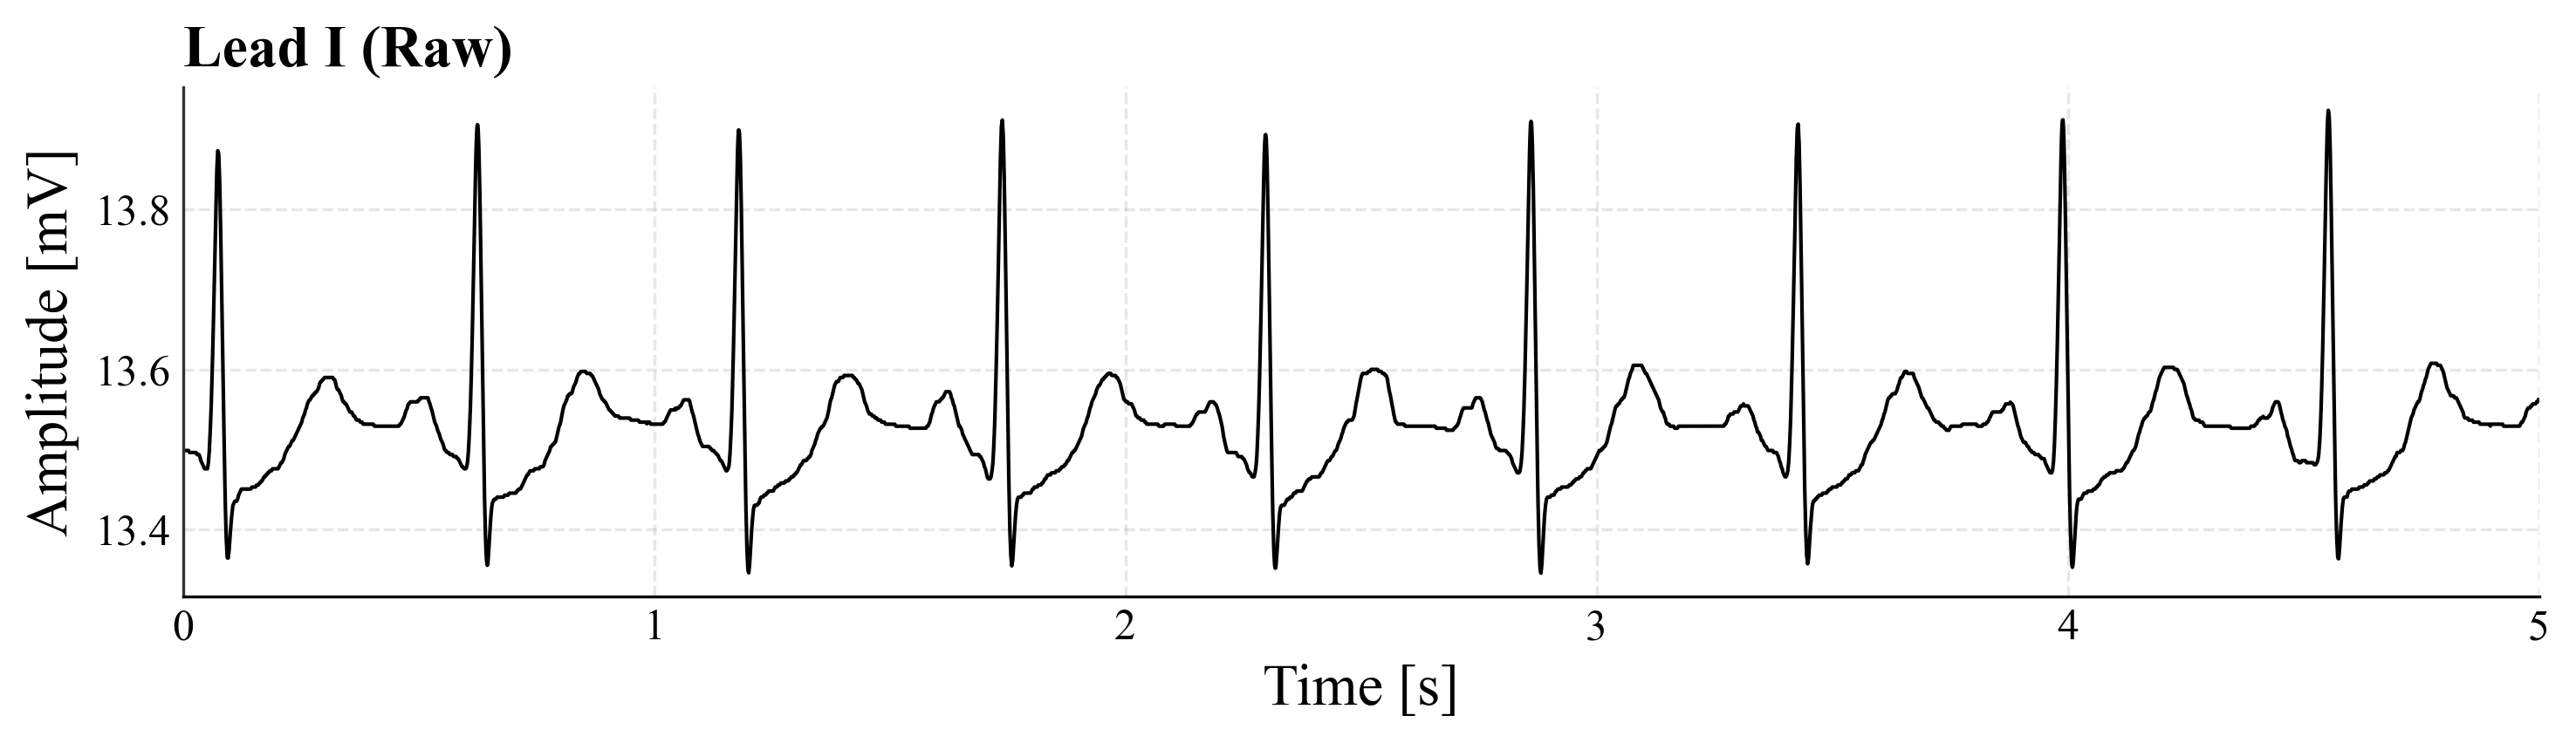

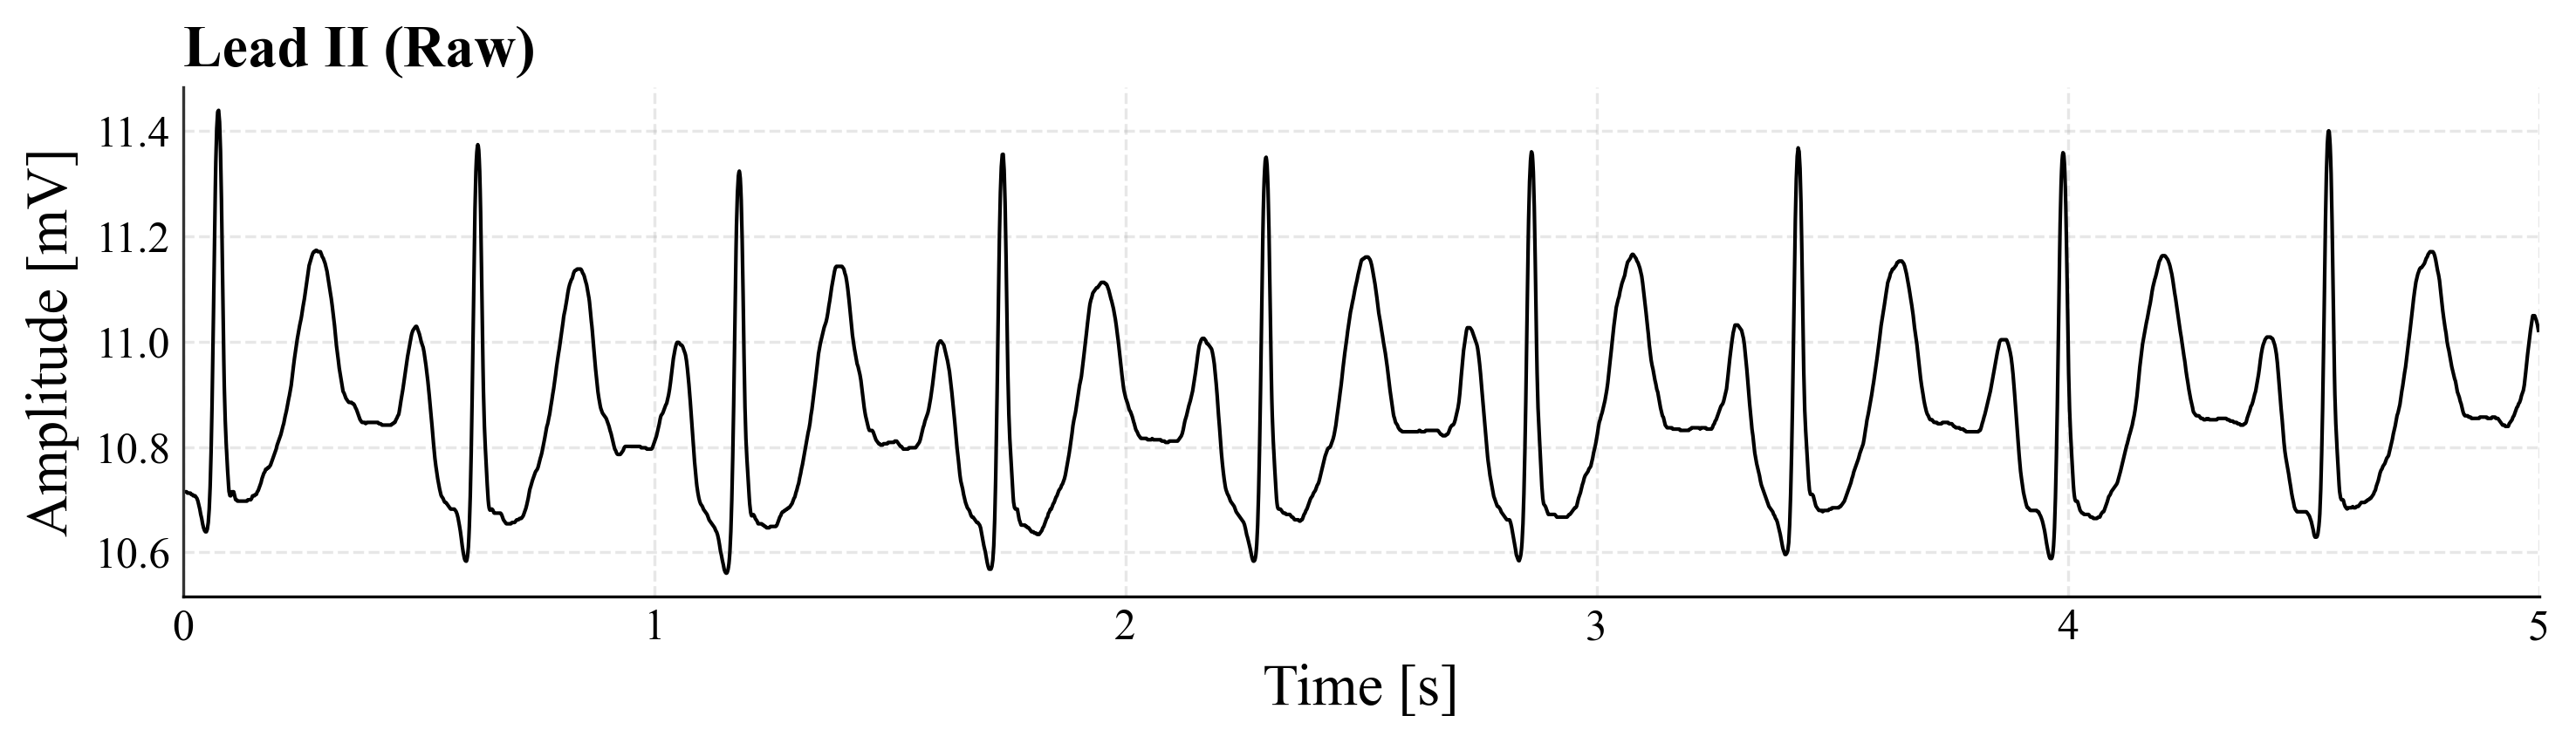

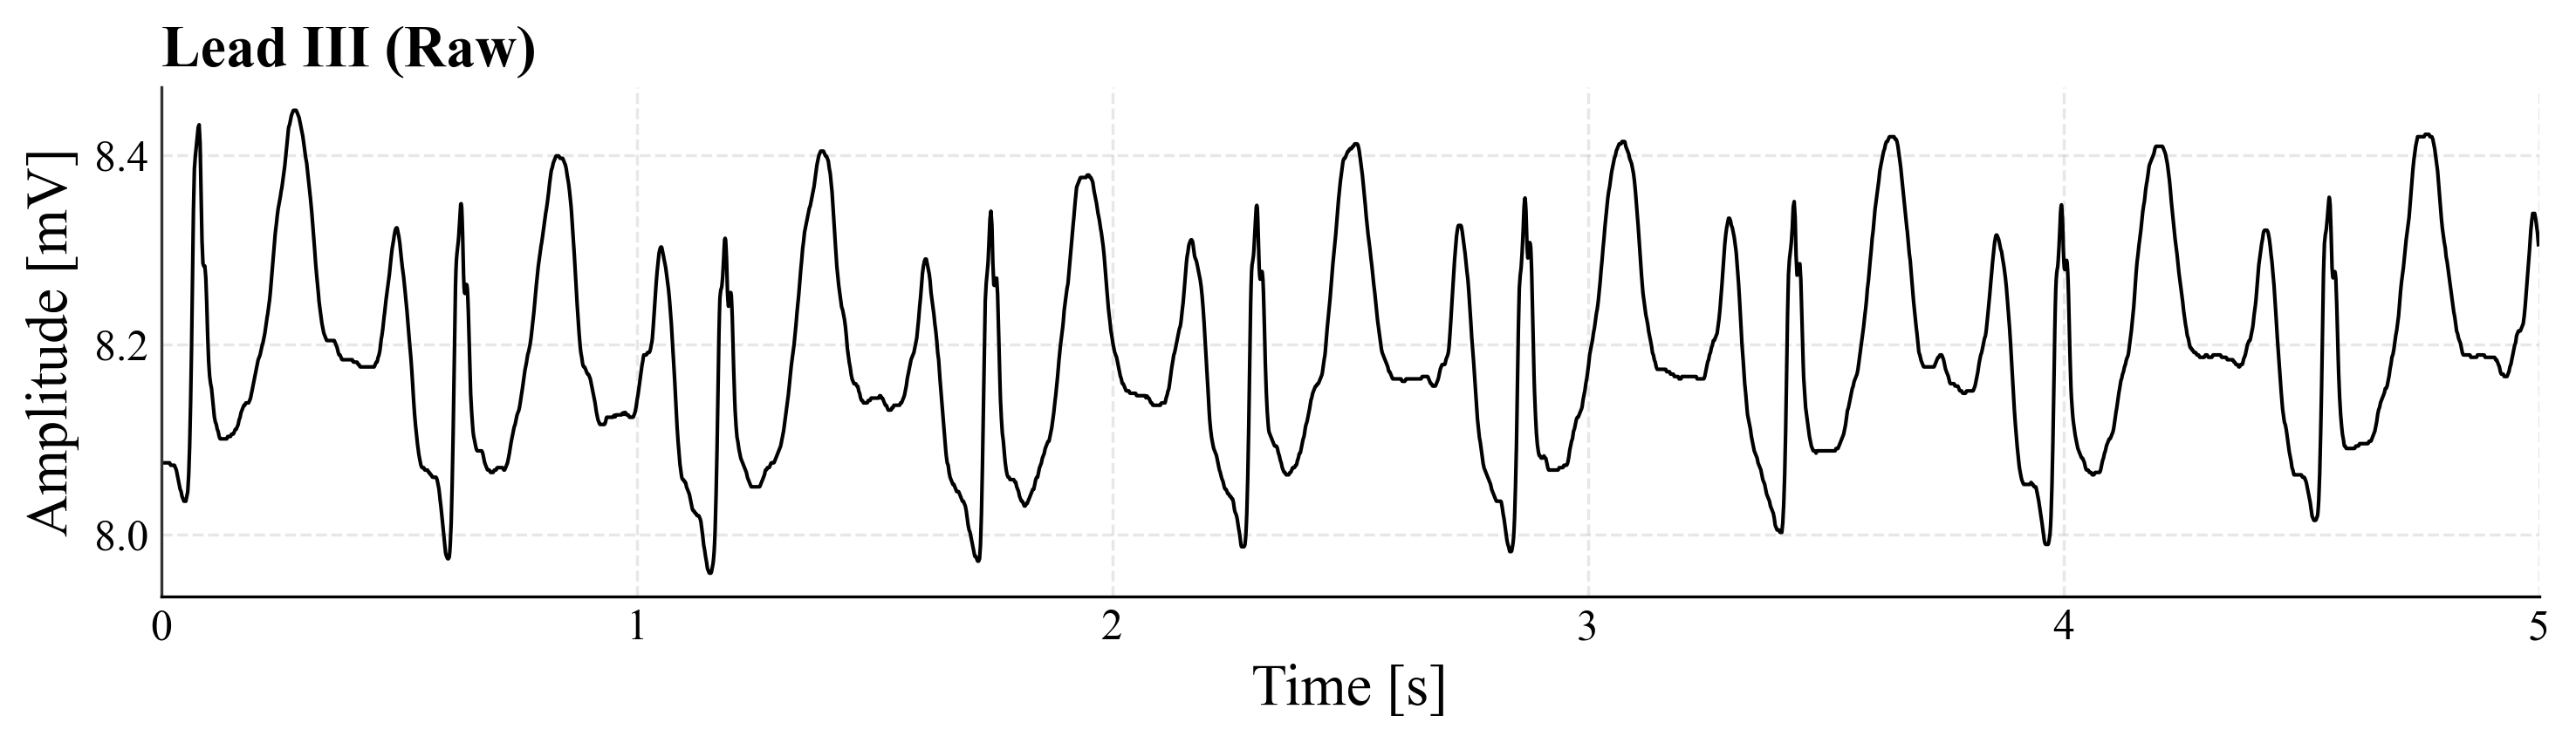

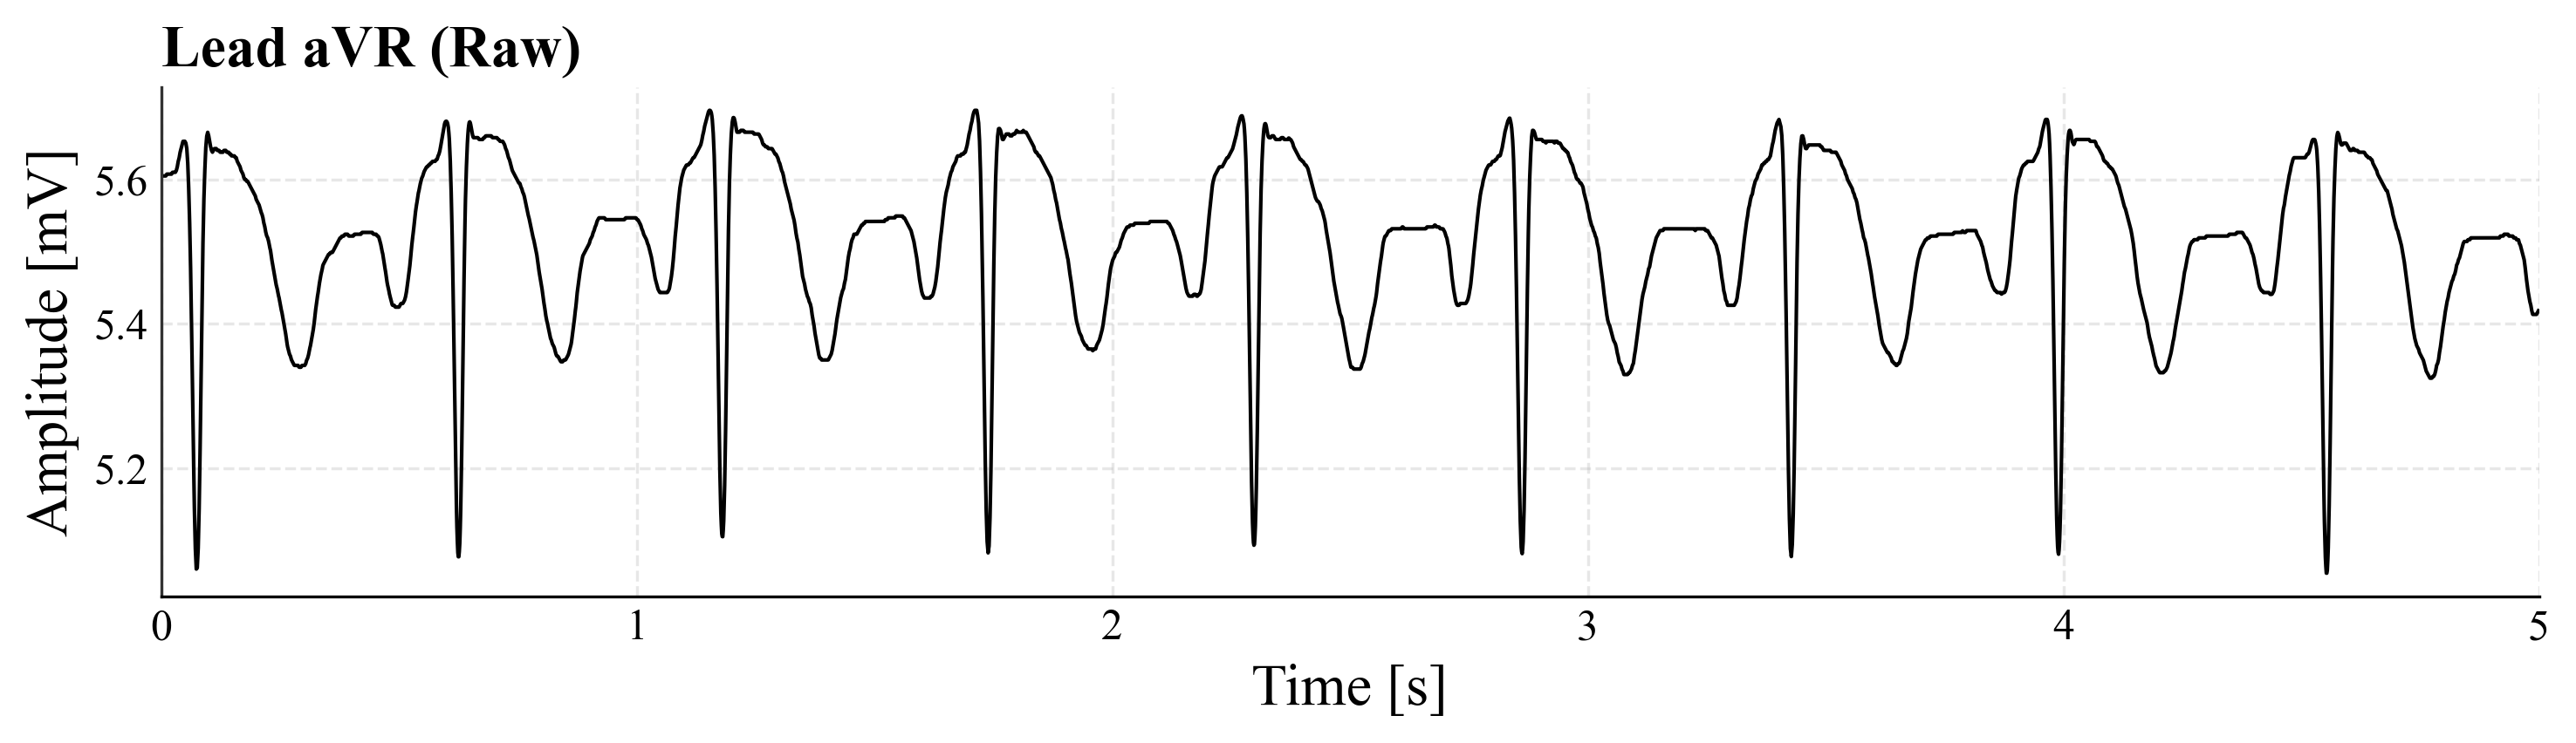

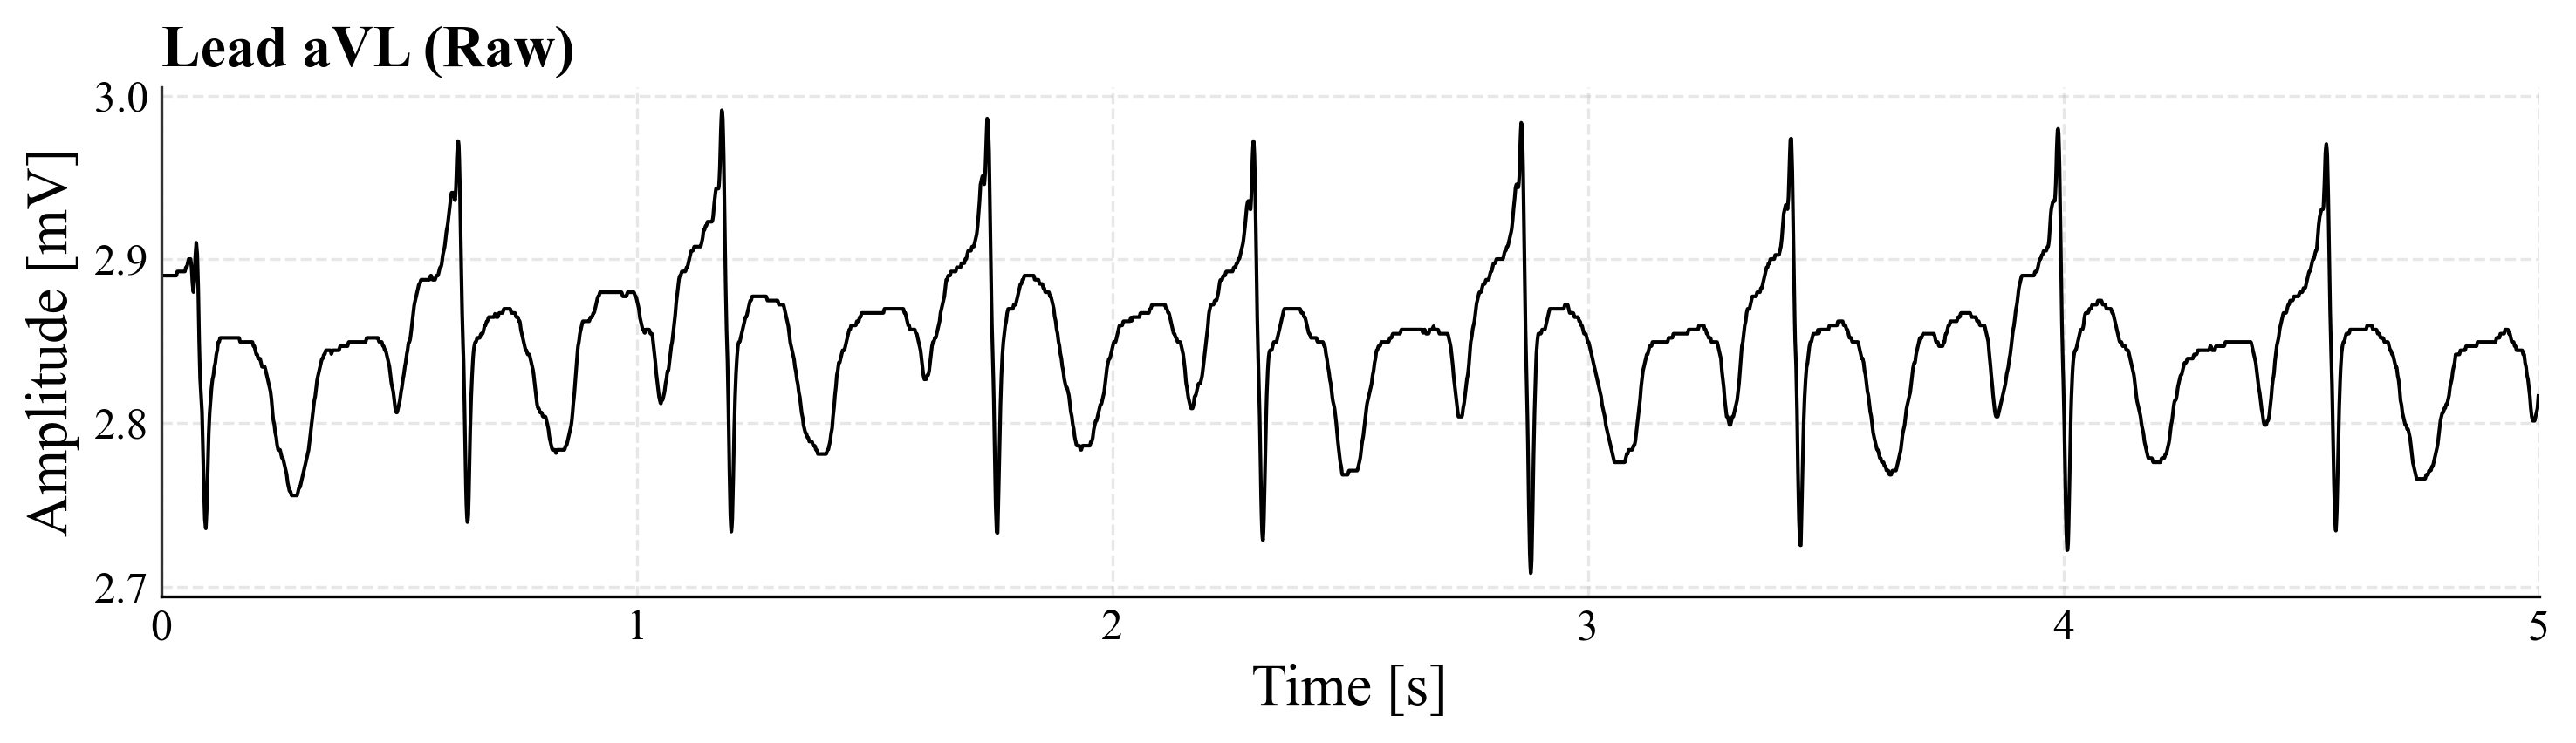

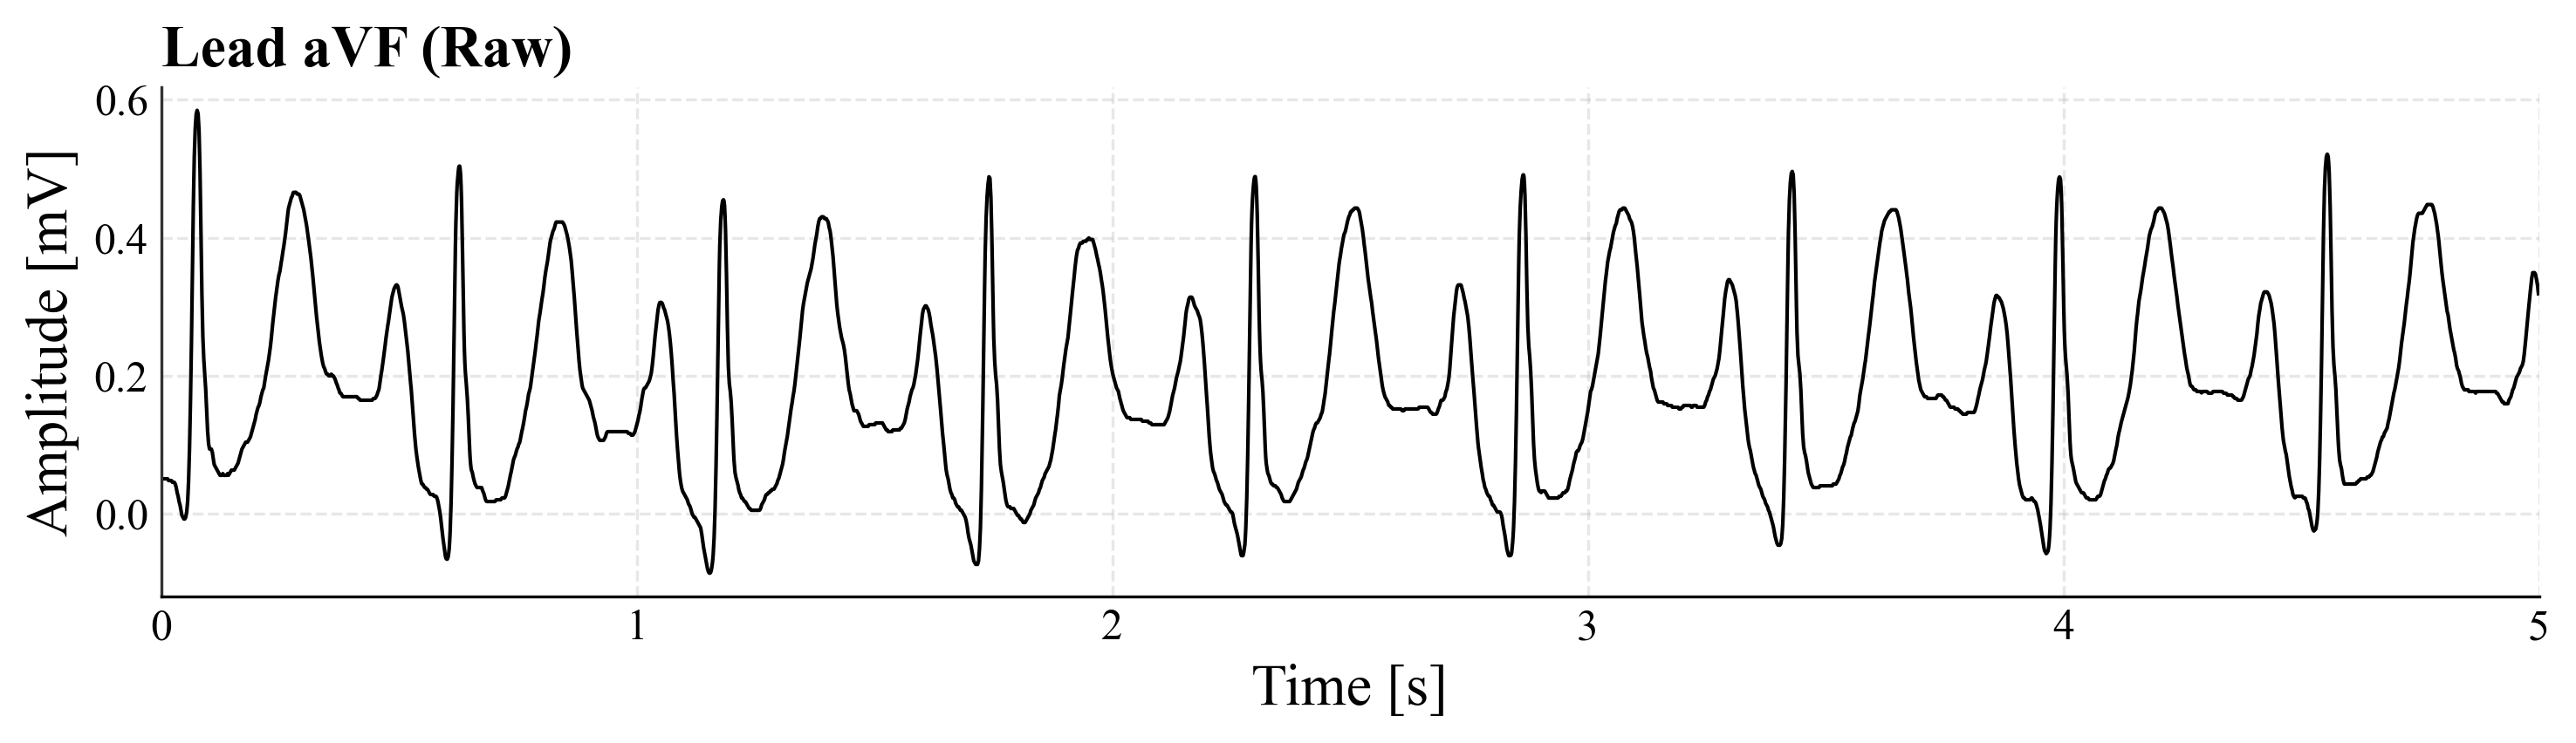

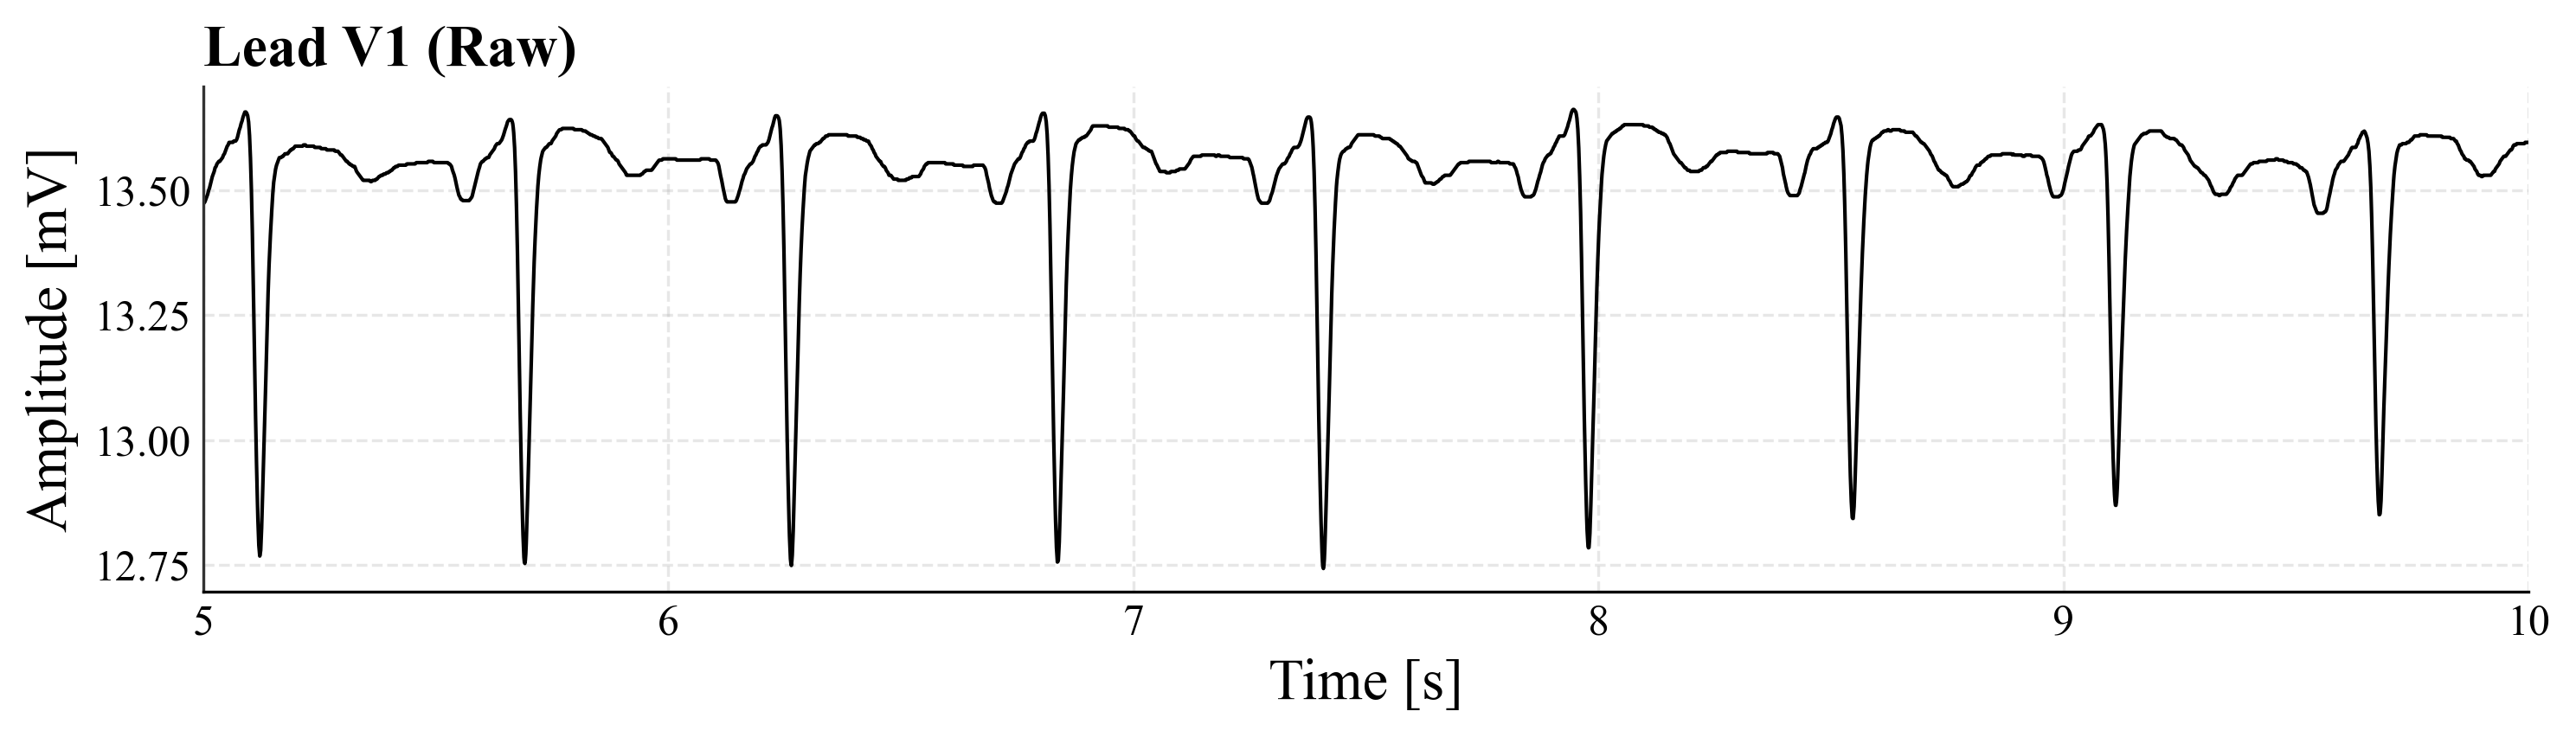

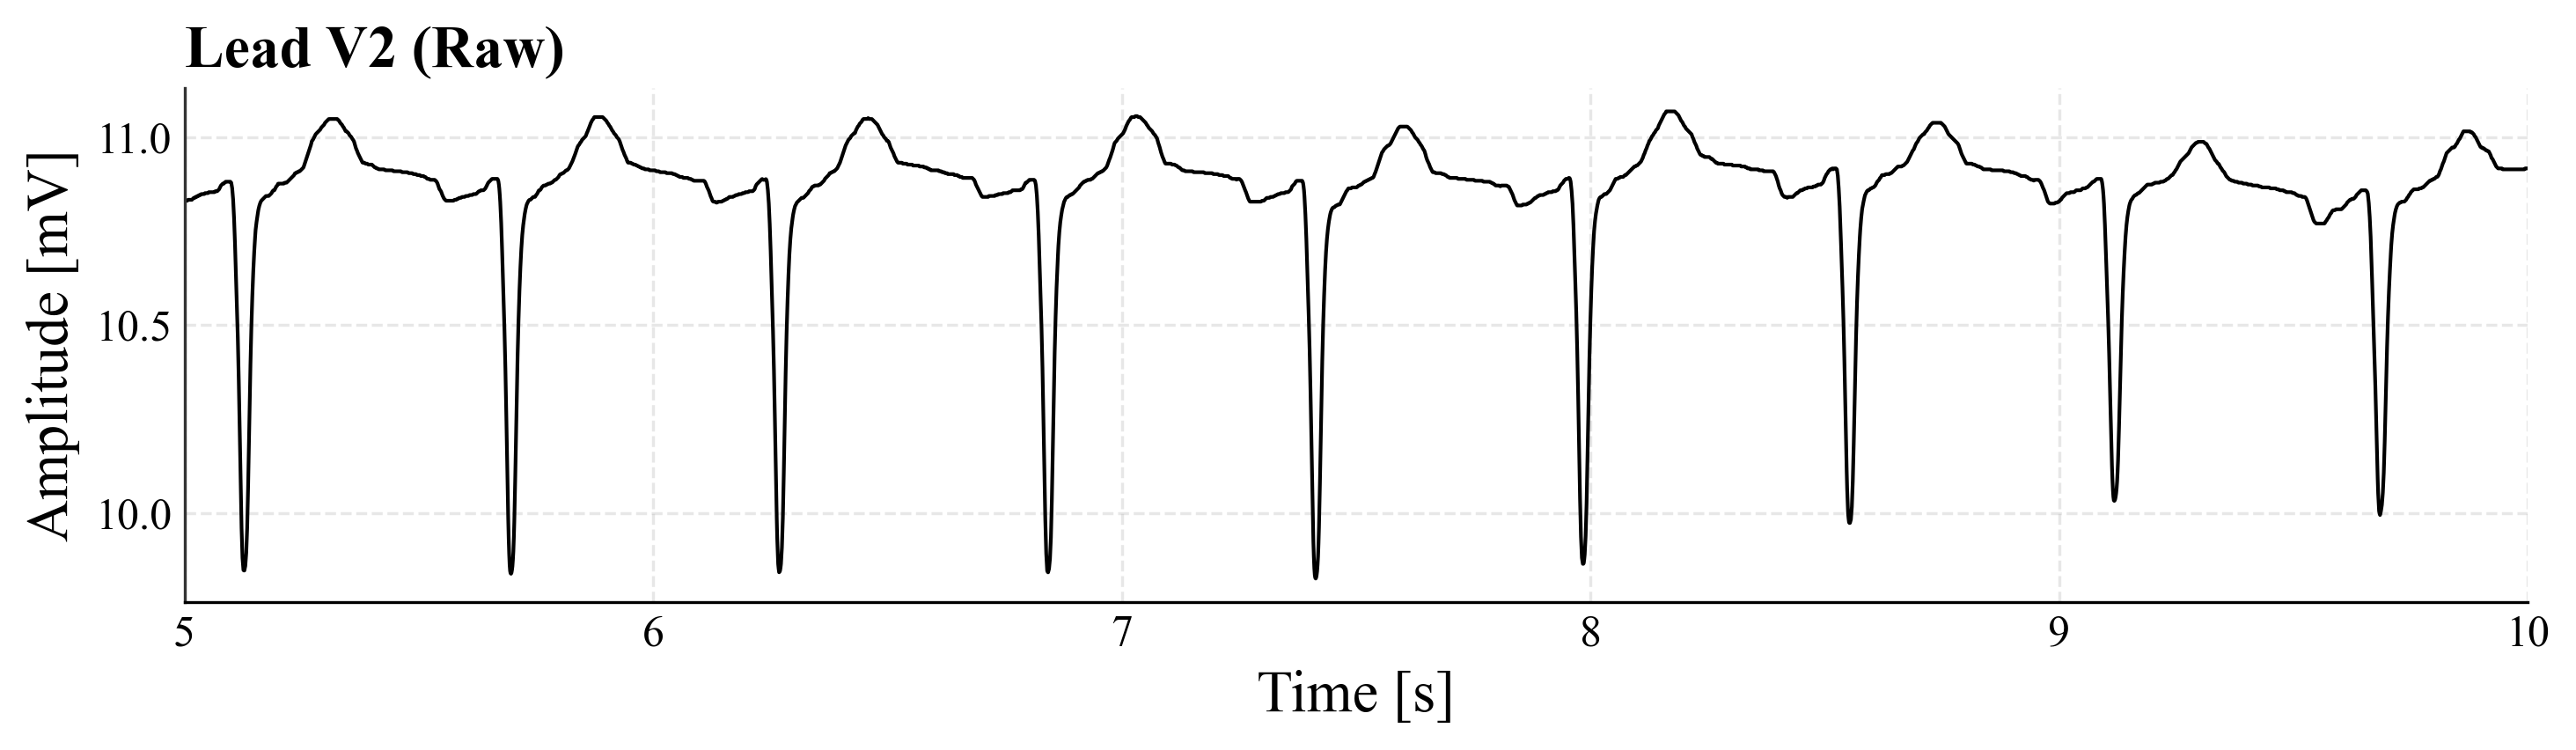

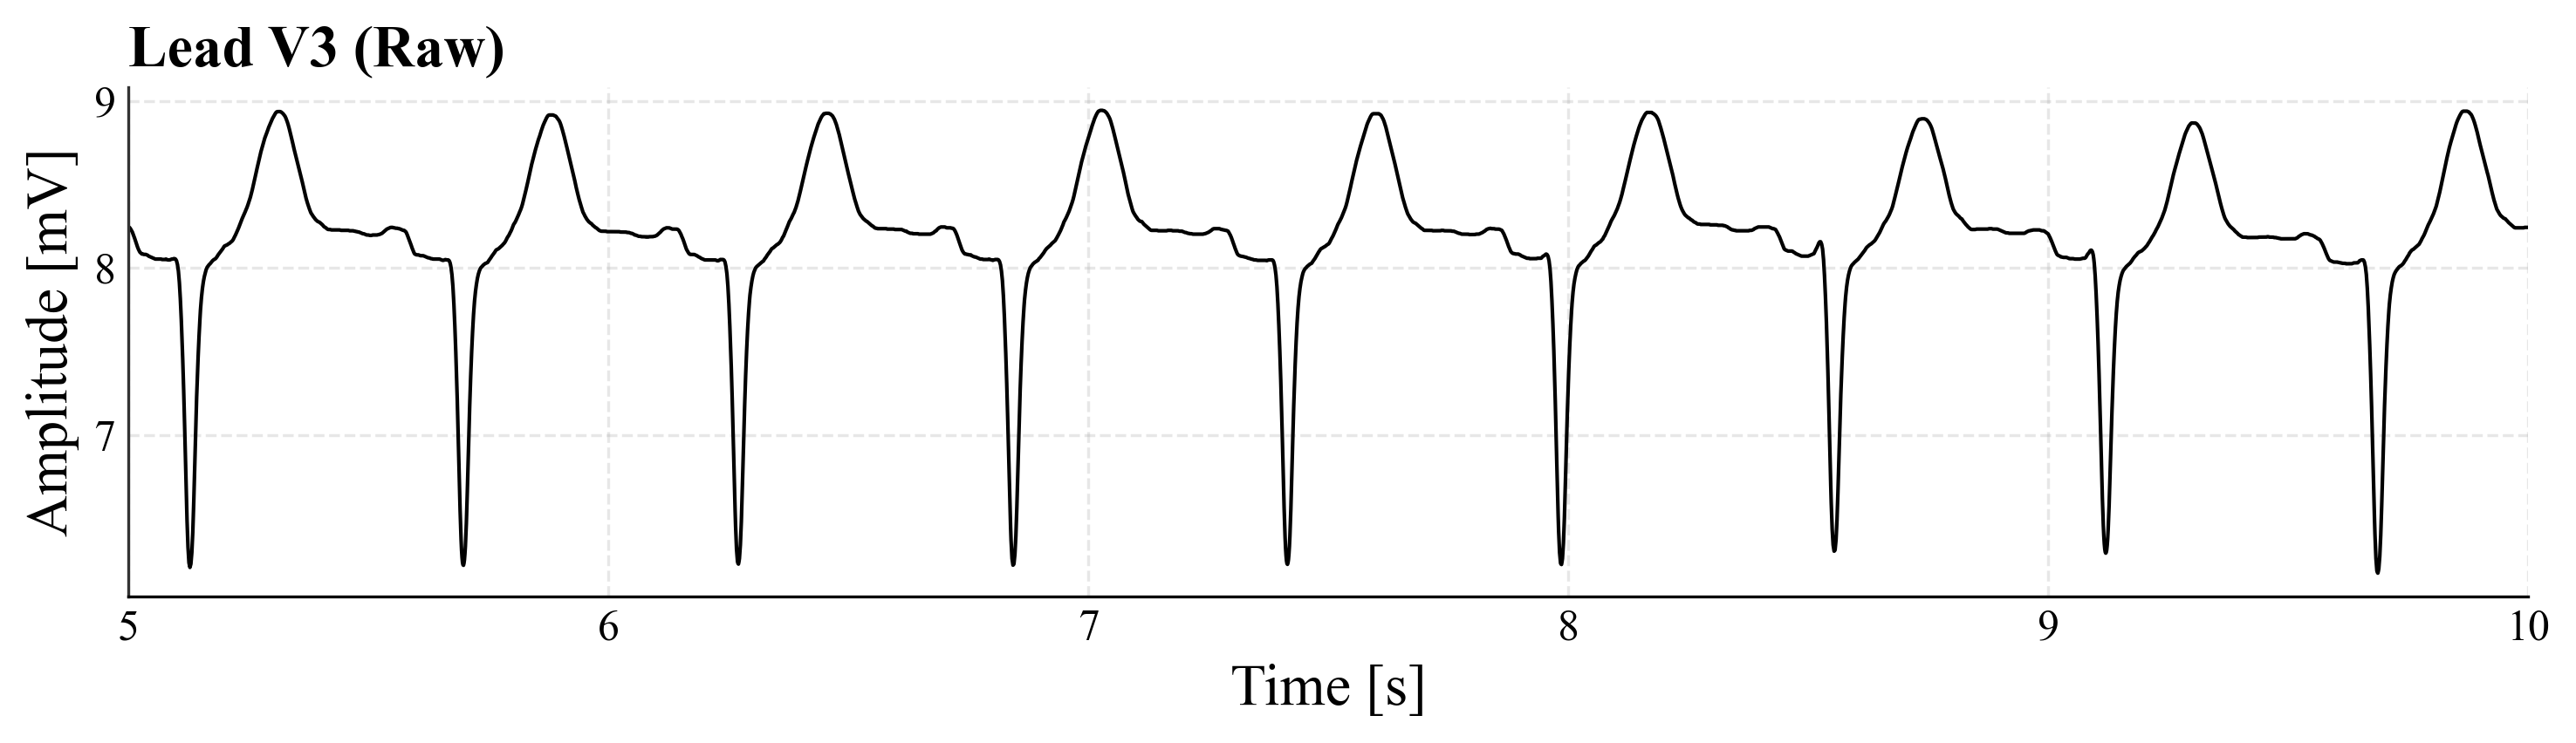

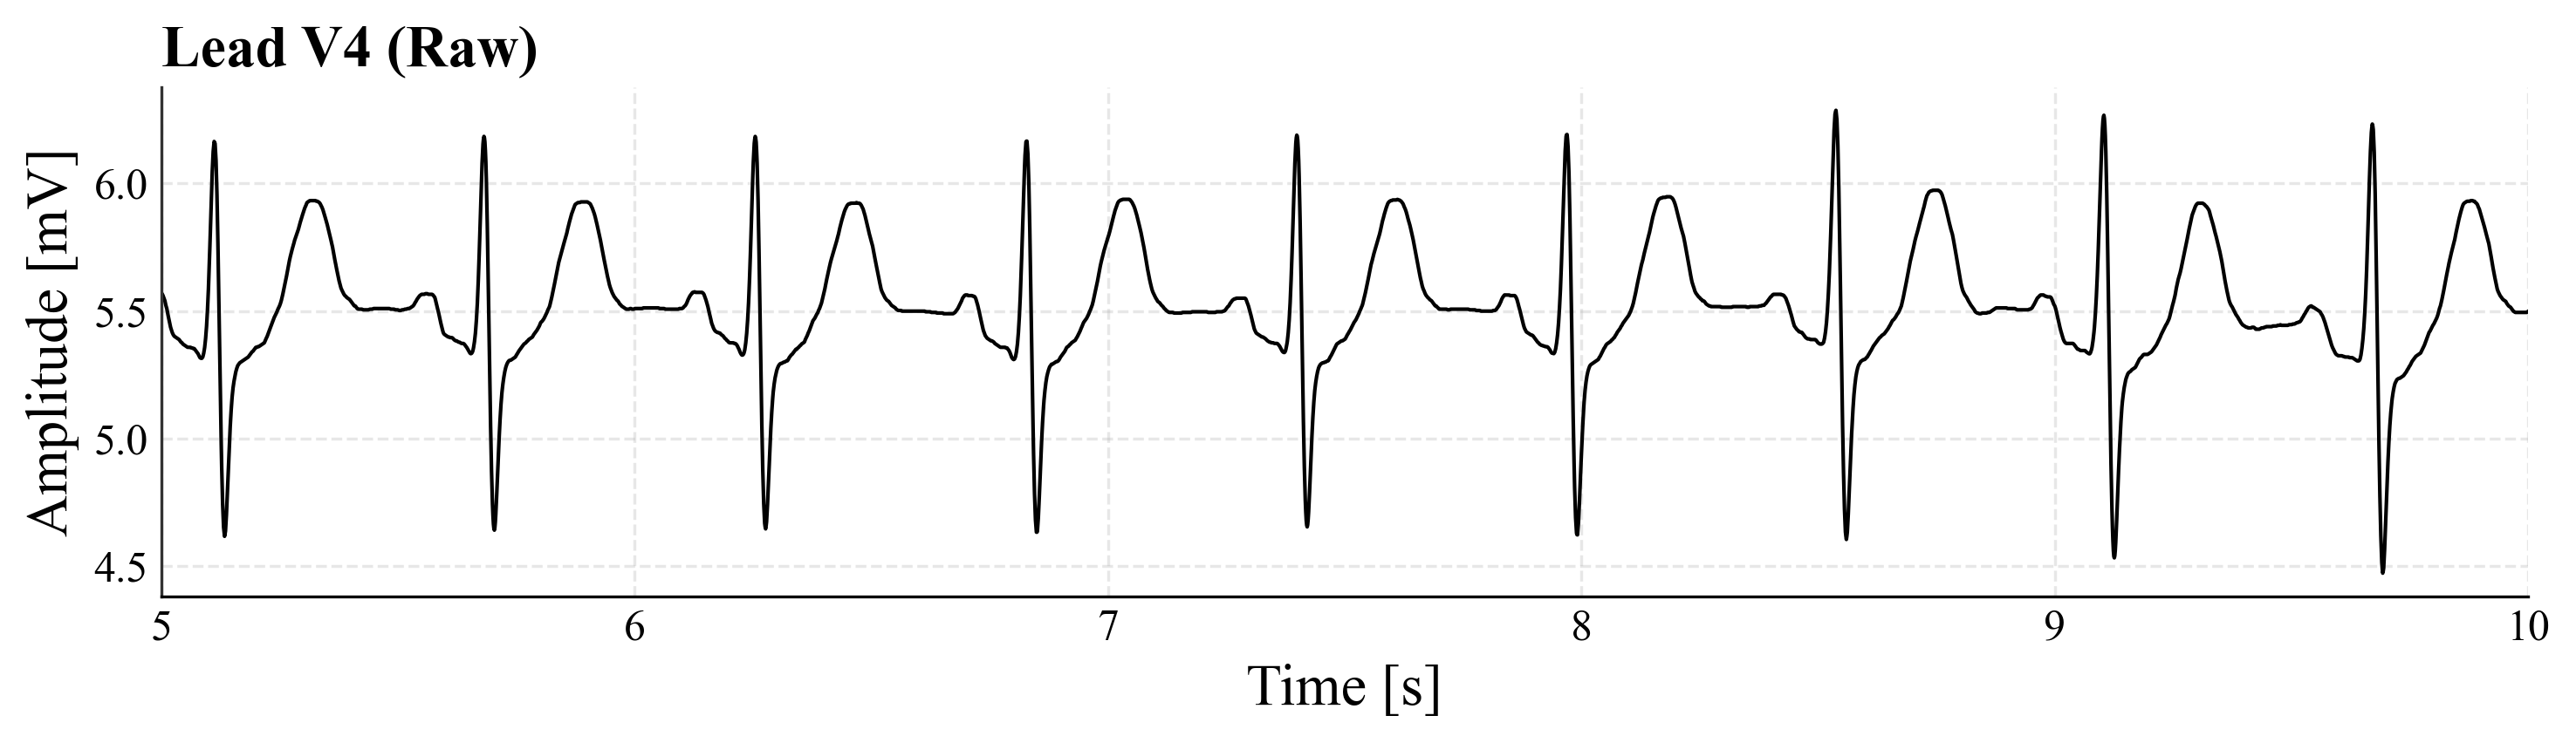

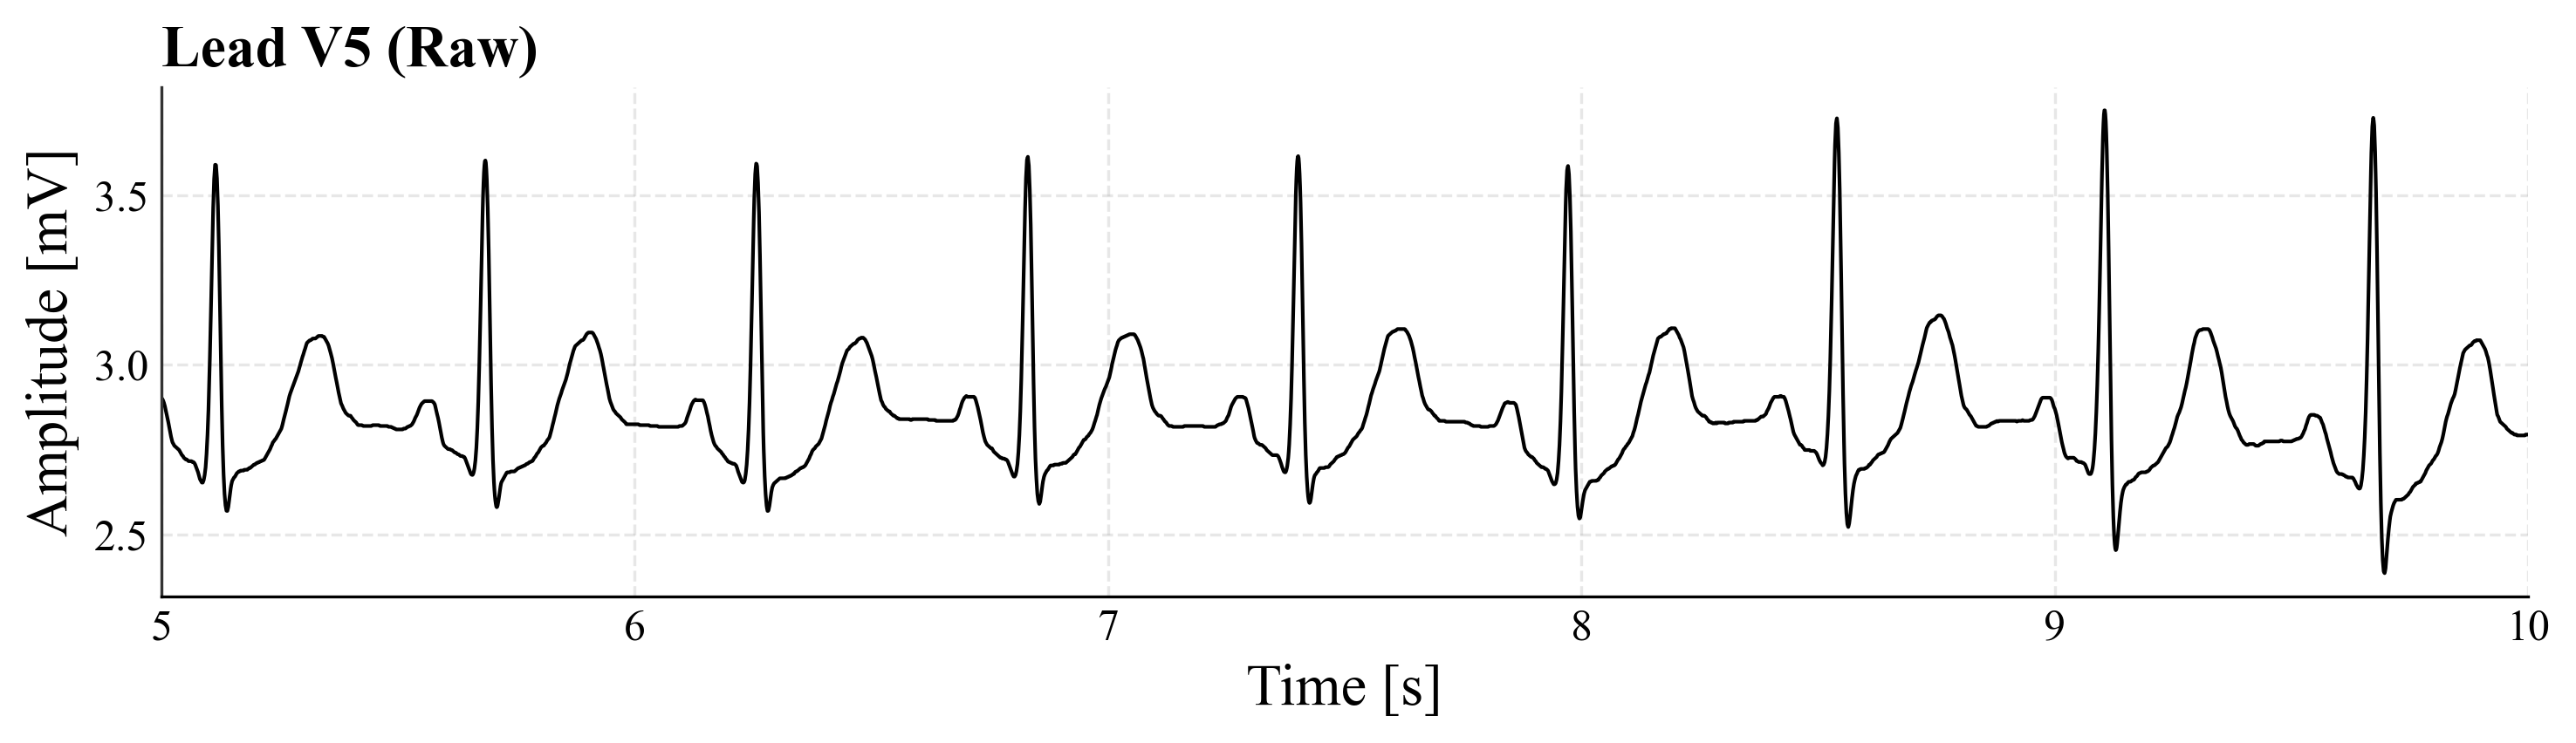

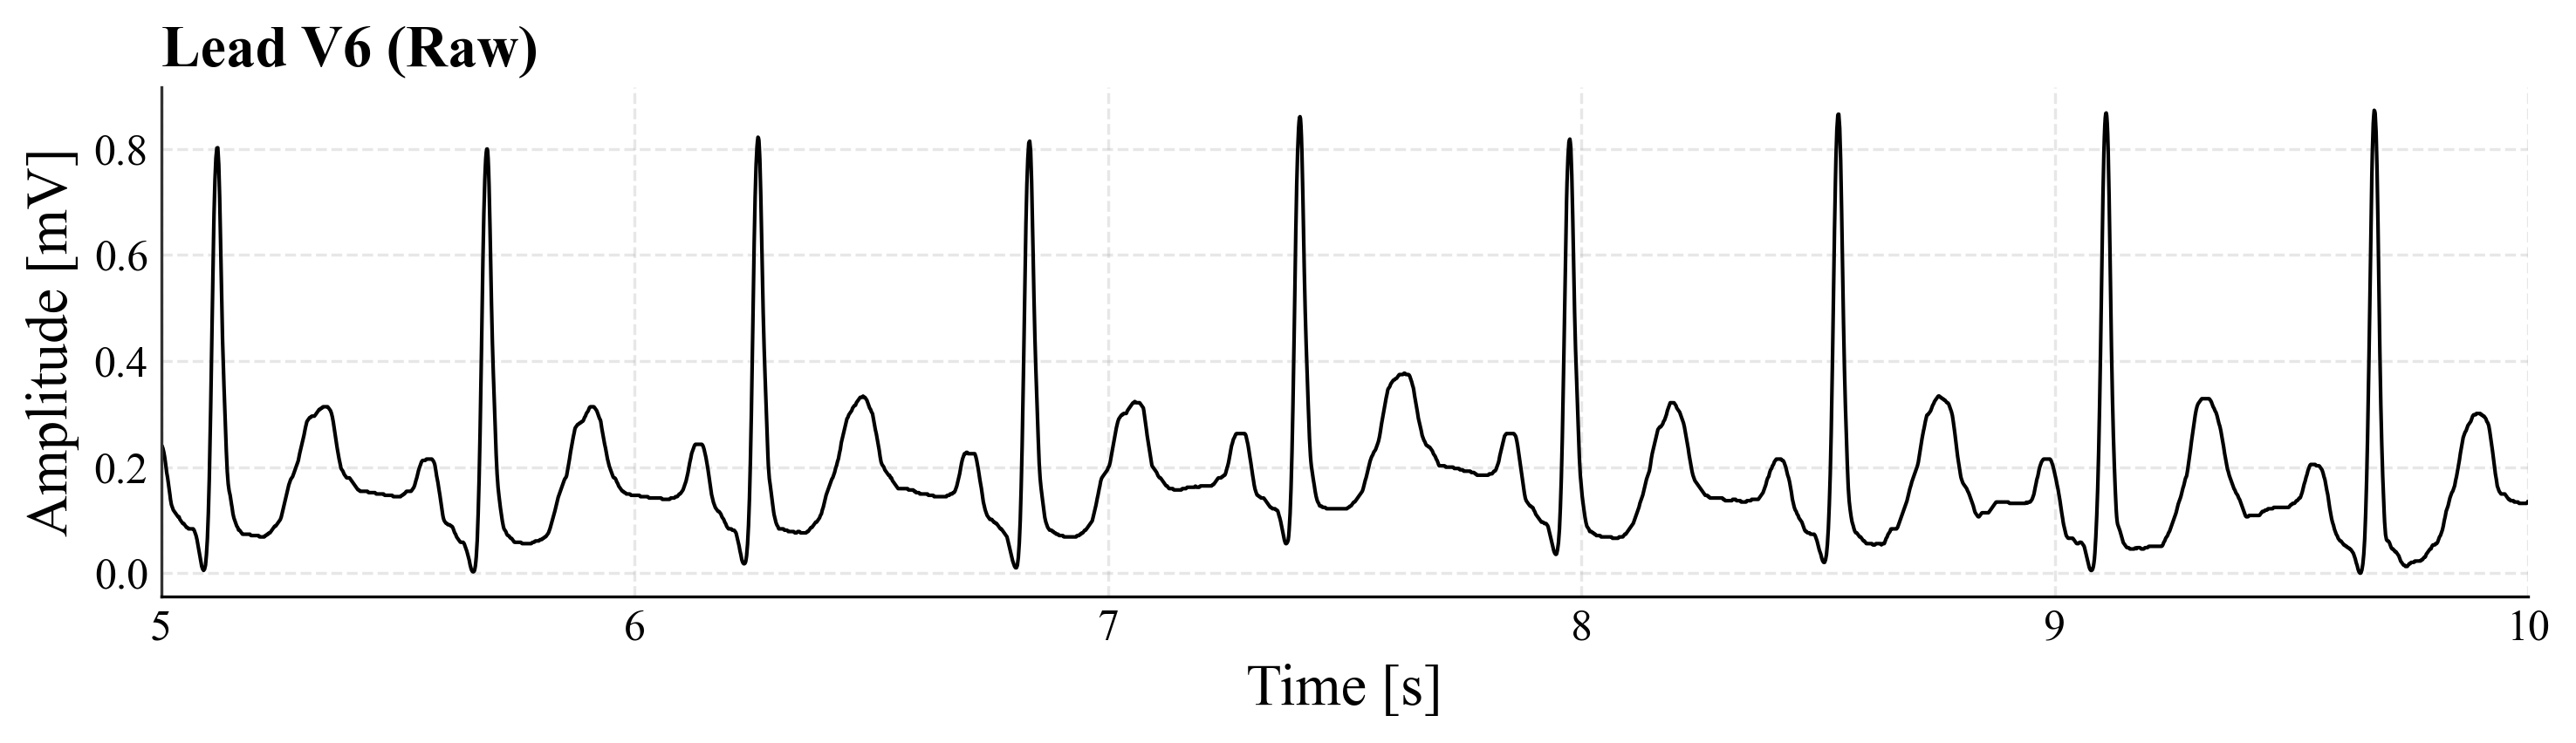

--- CLEANED ECG Signals for Patient 4 ---


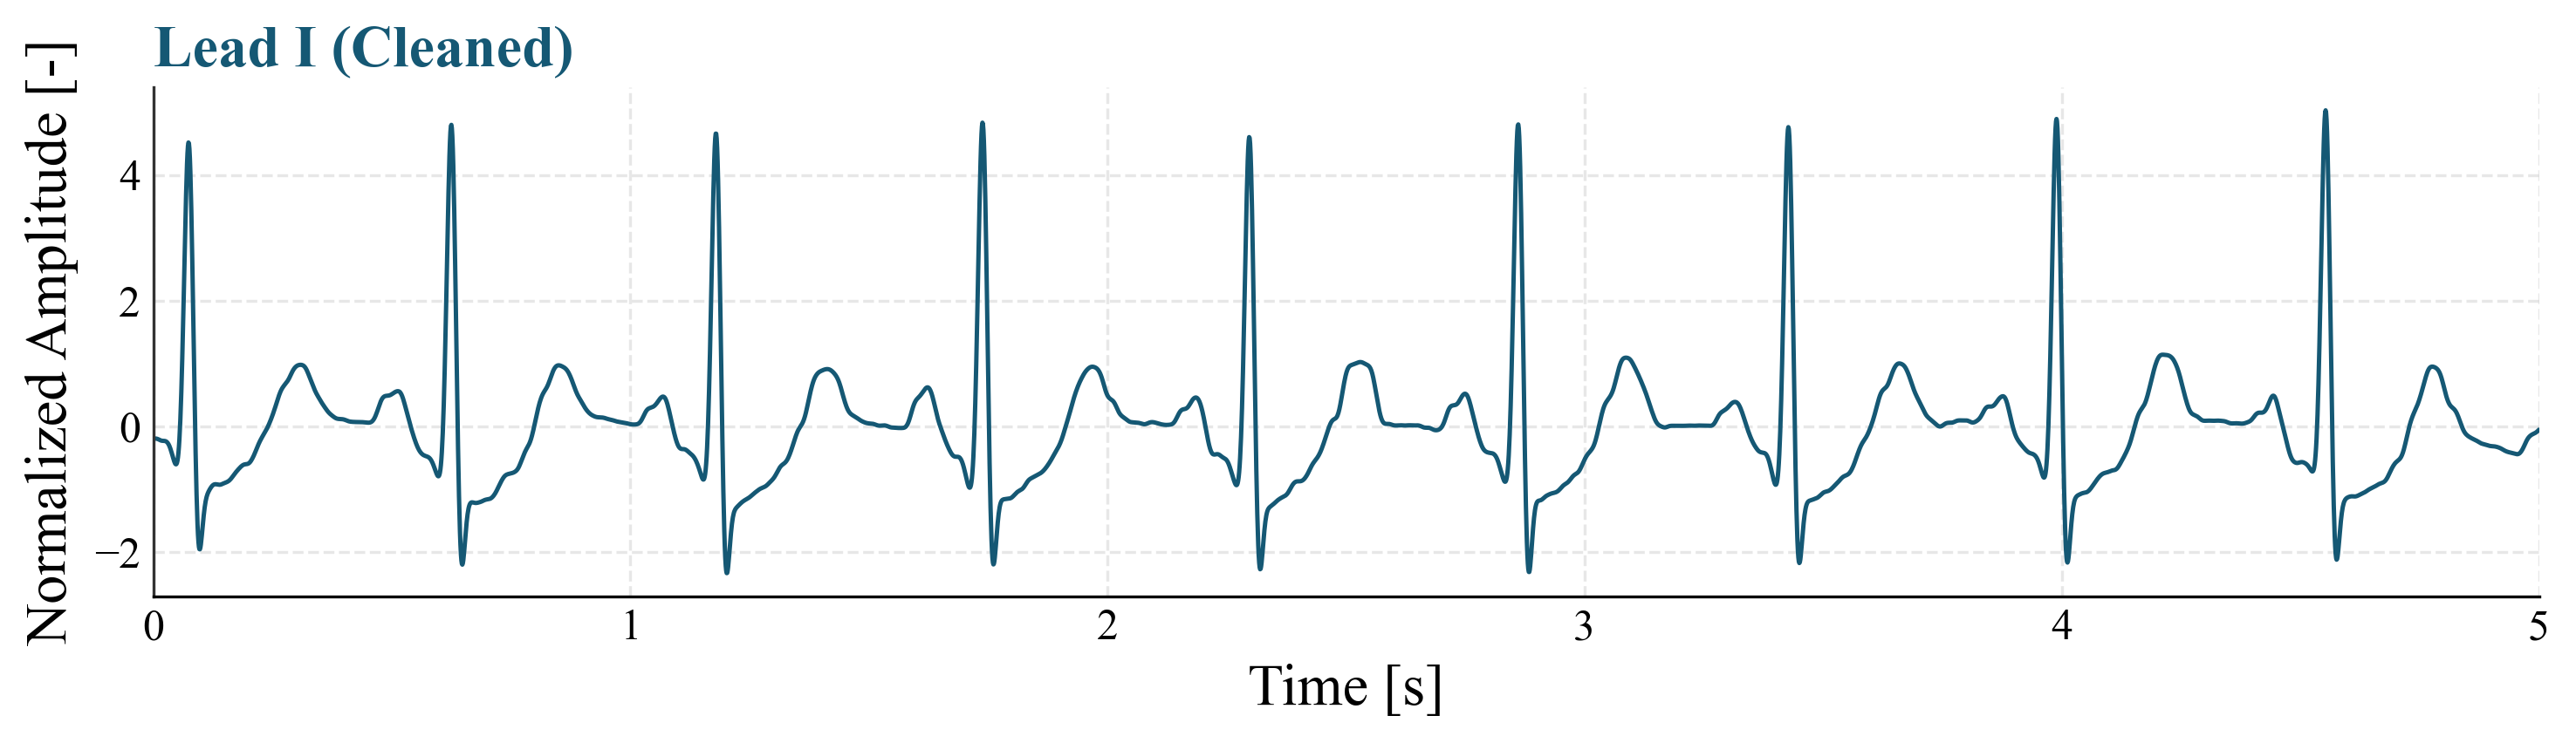

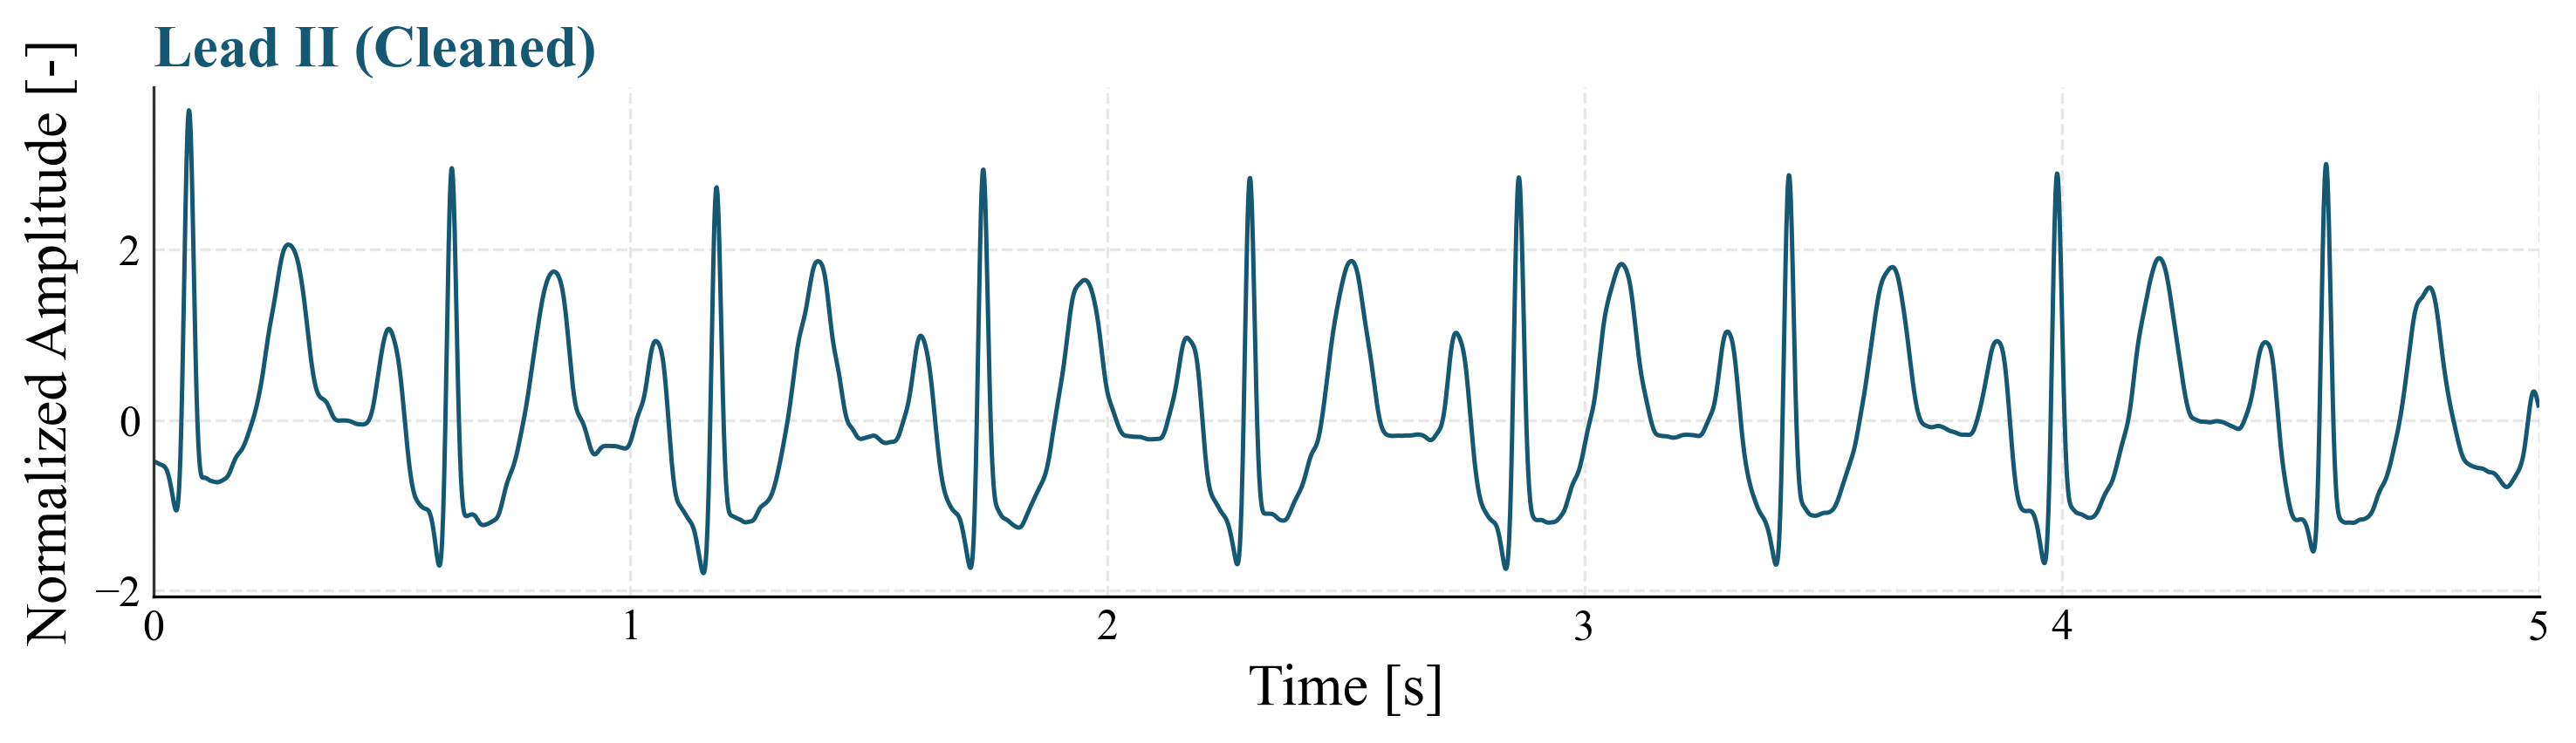

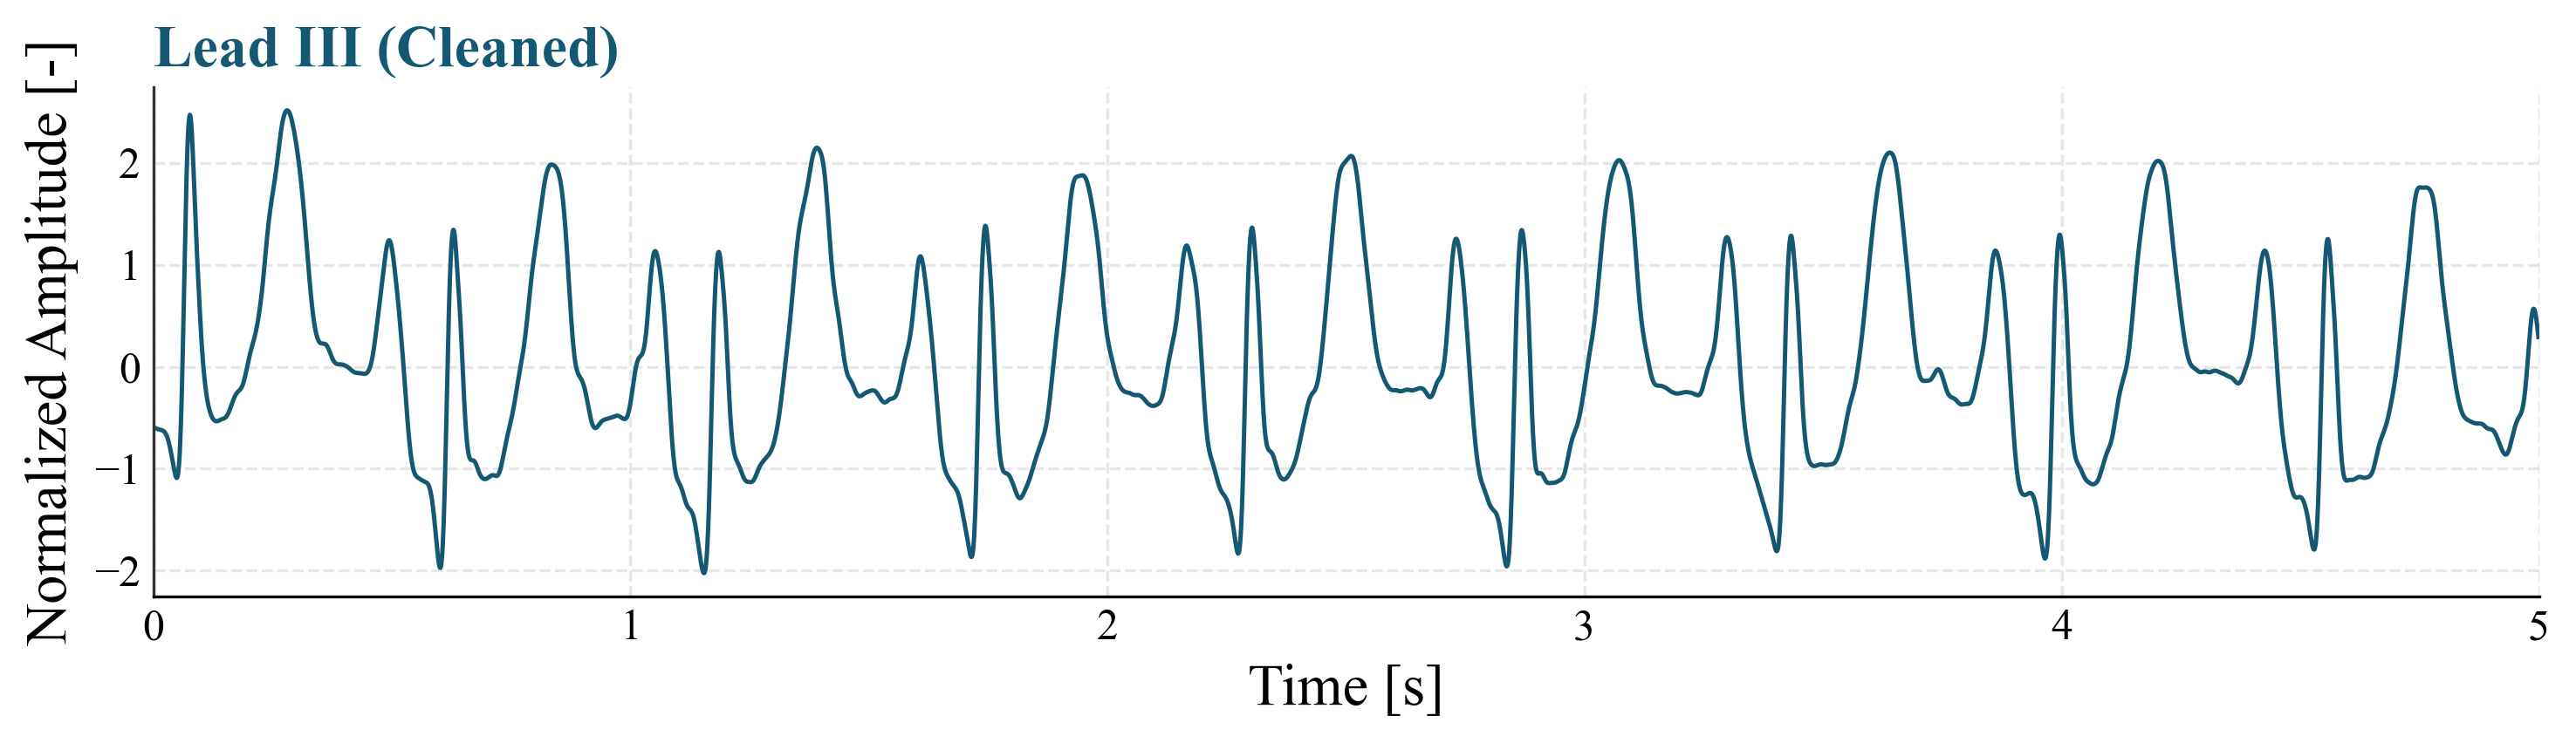

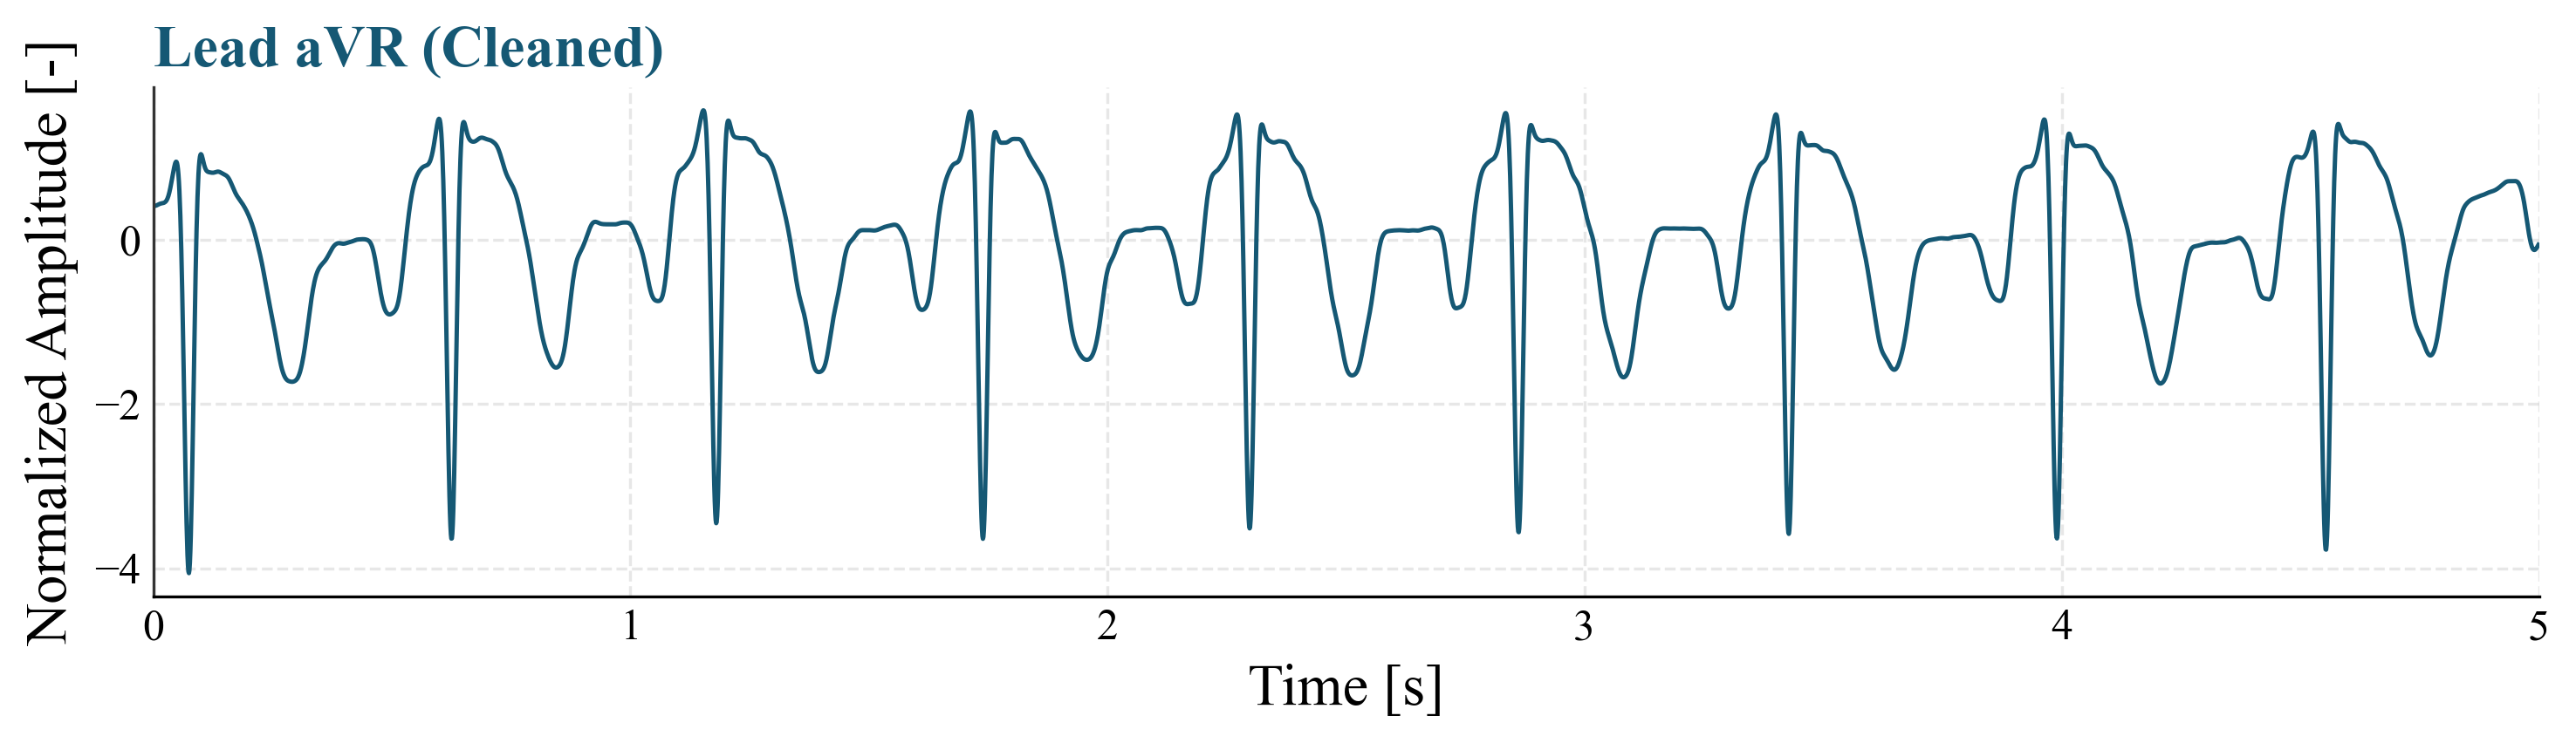

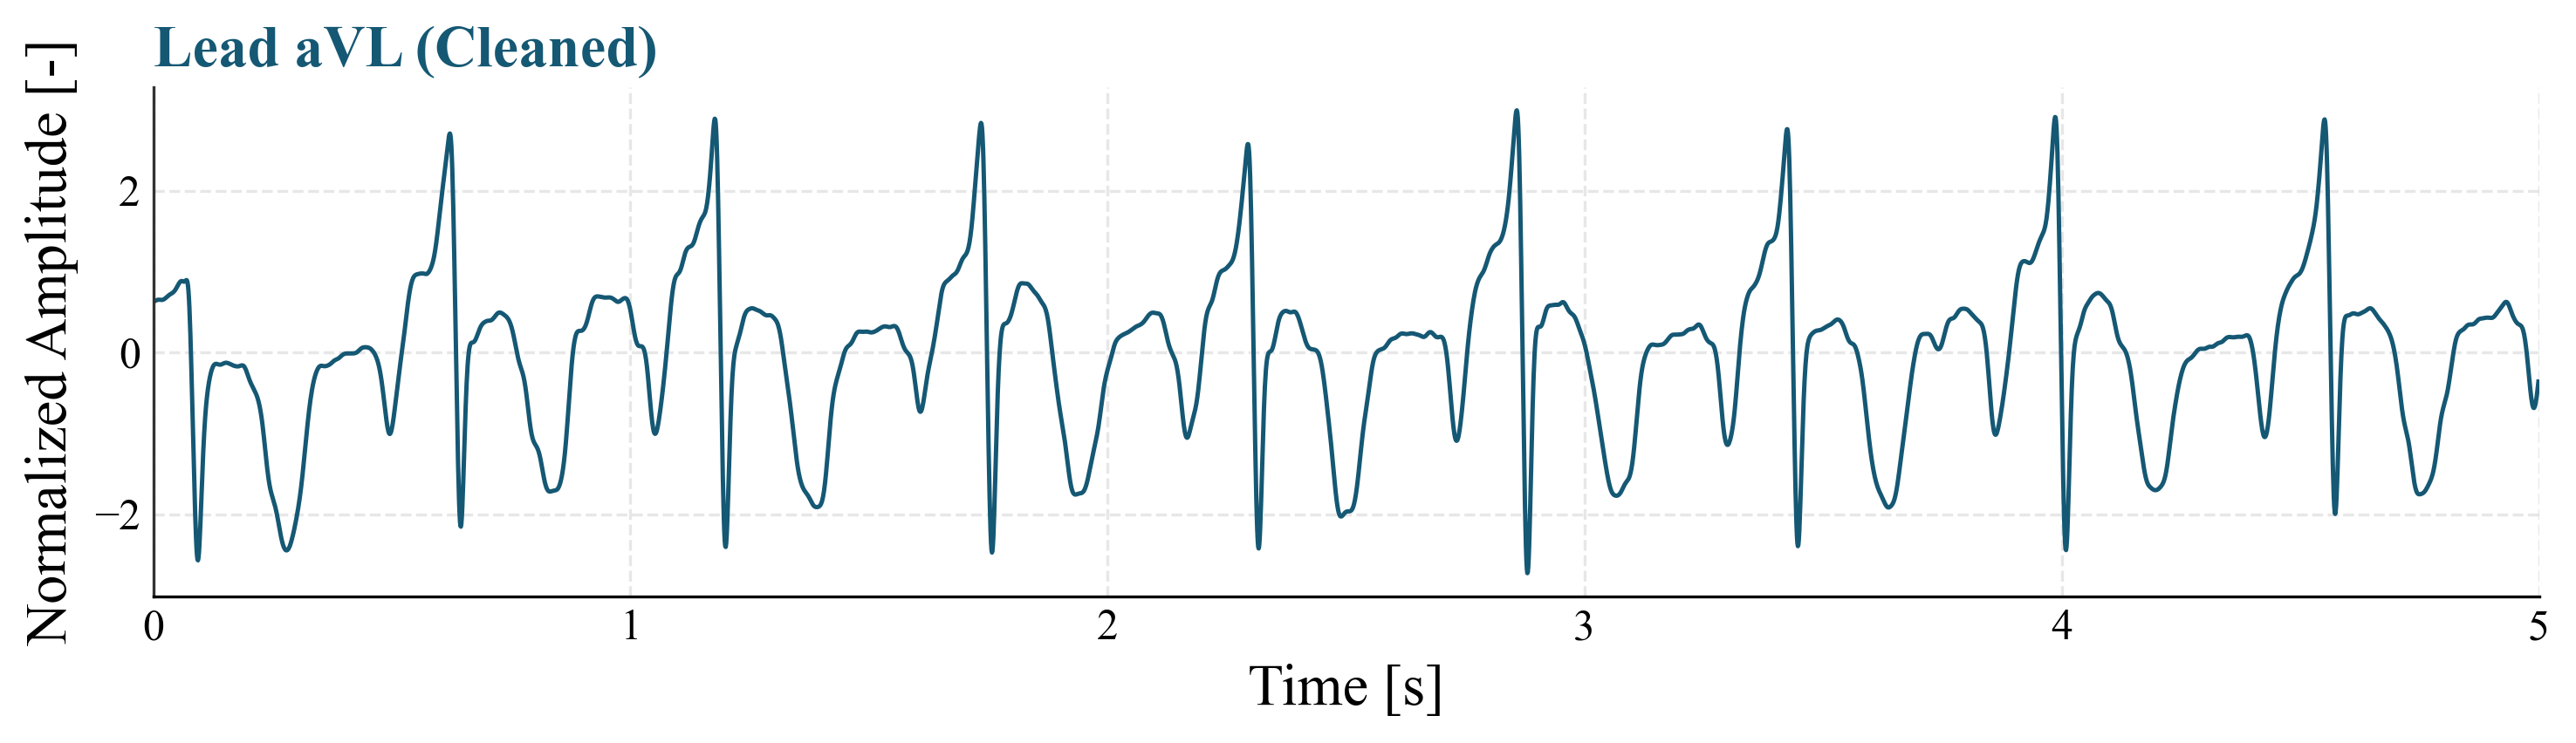

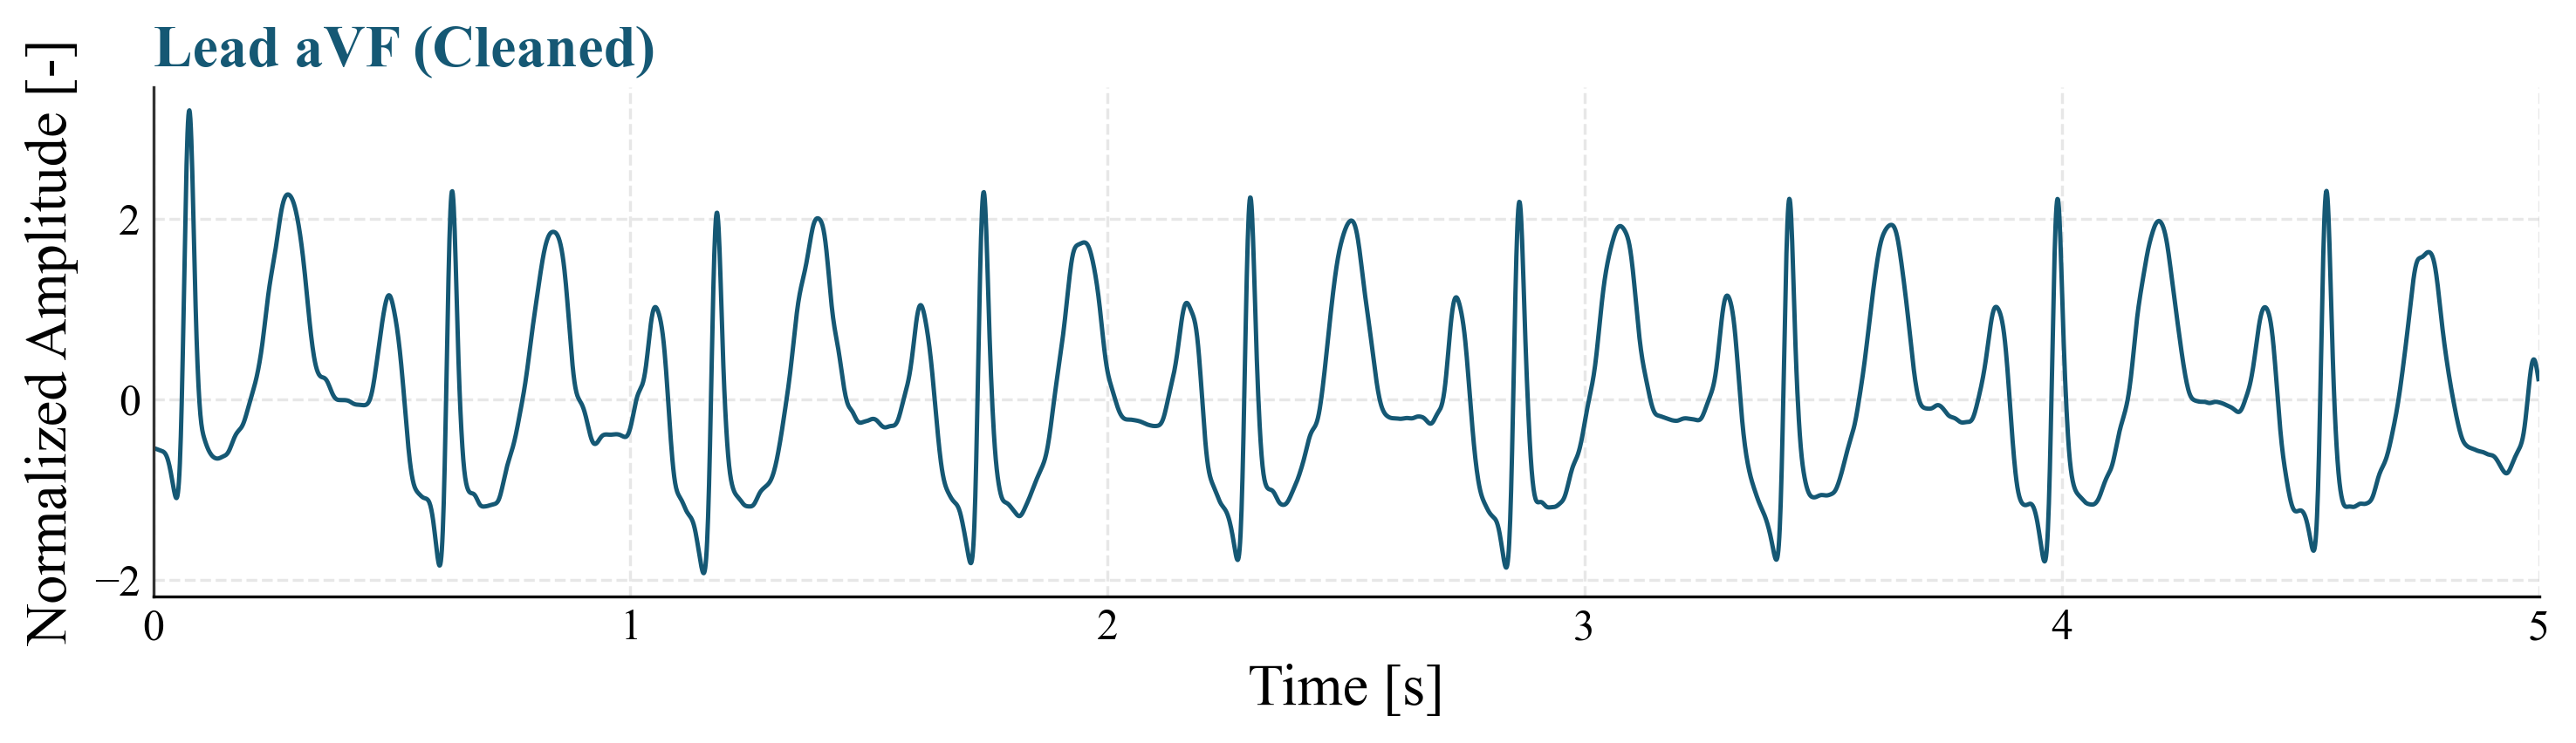

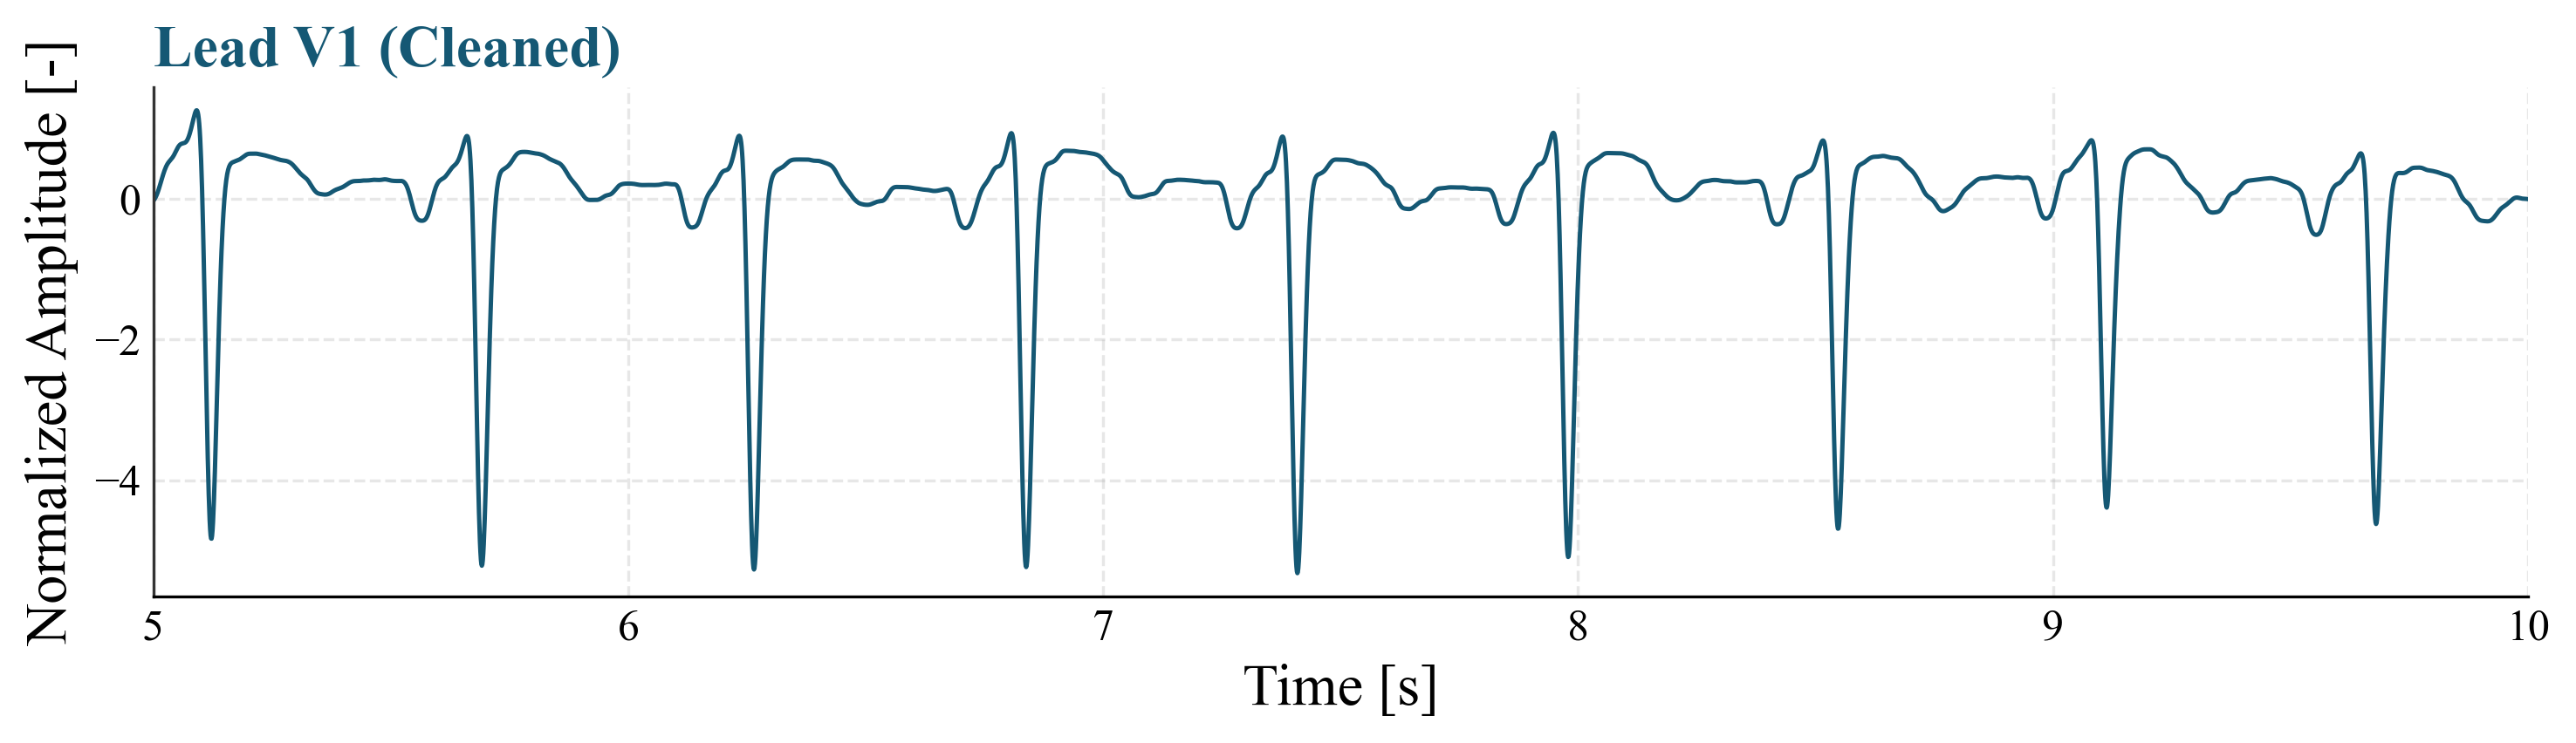

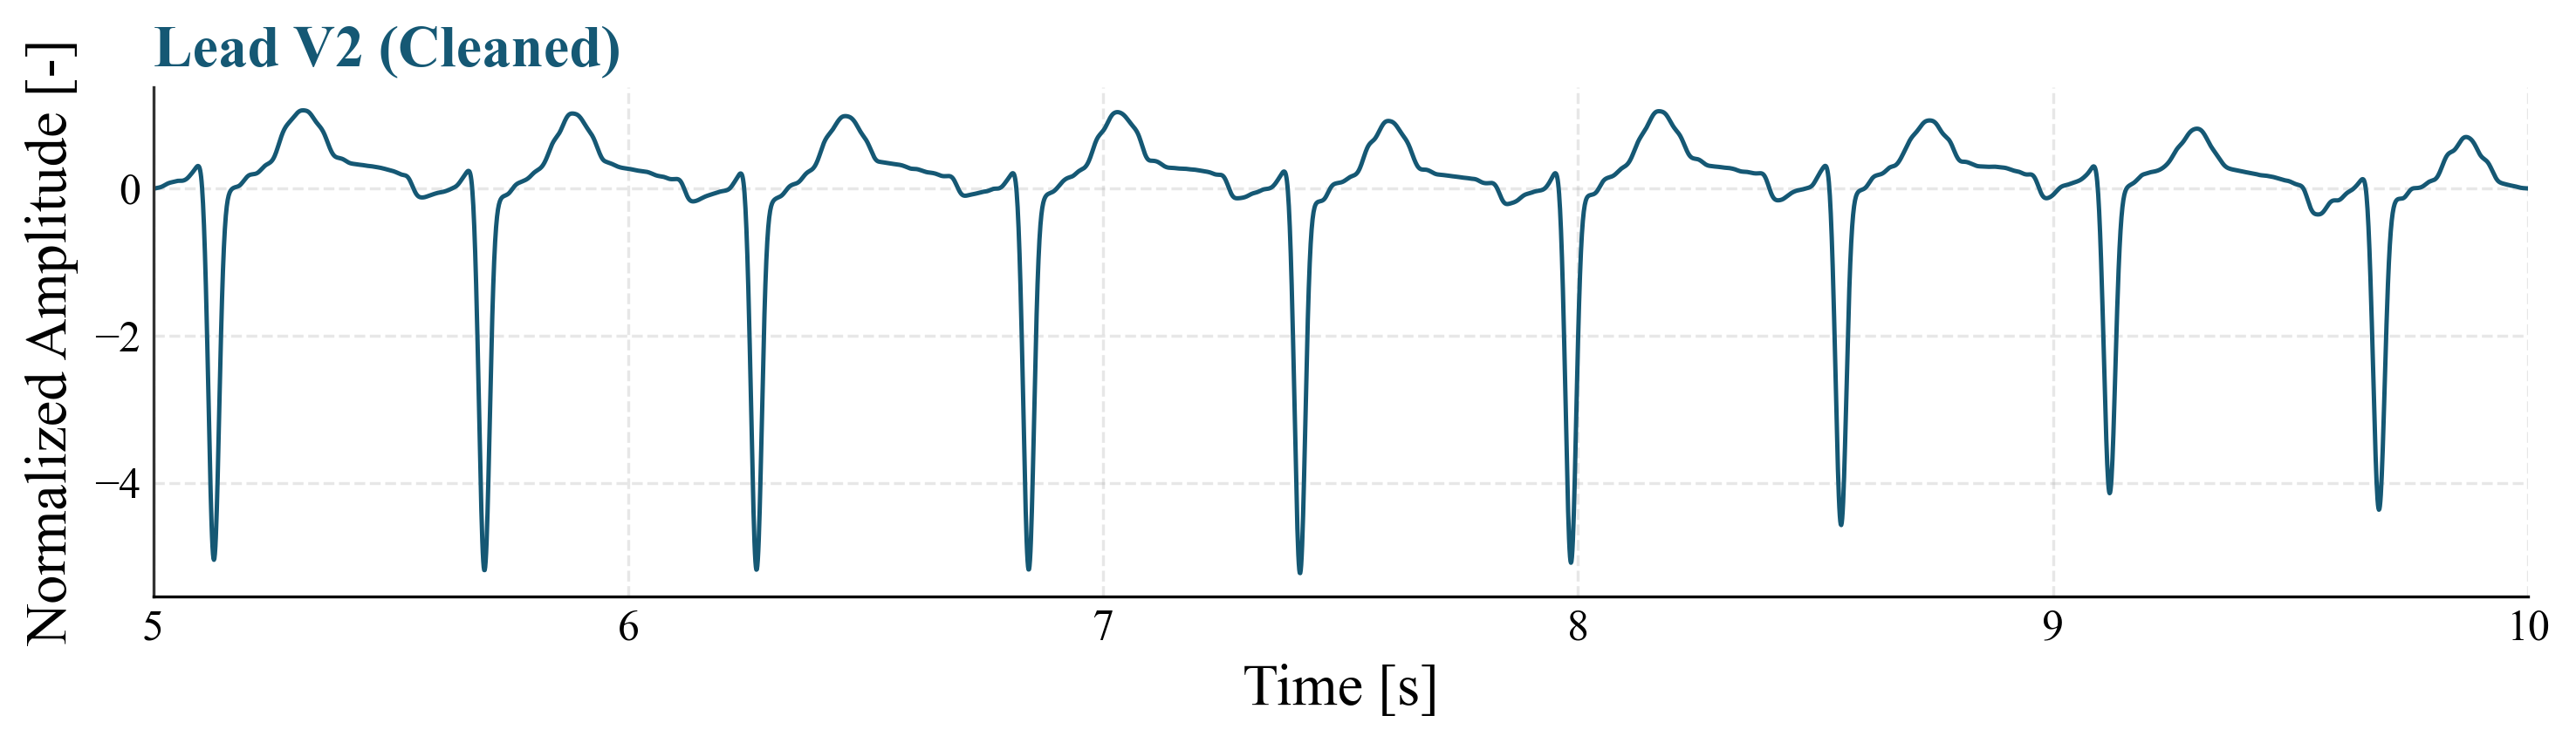

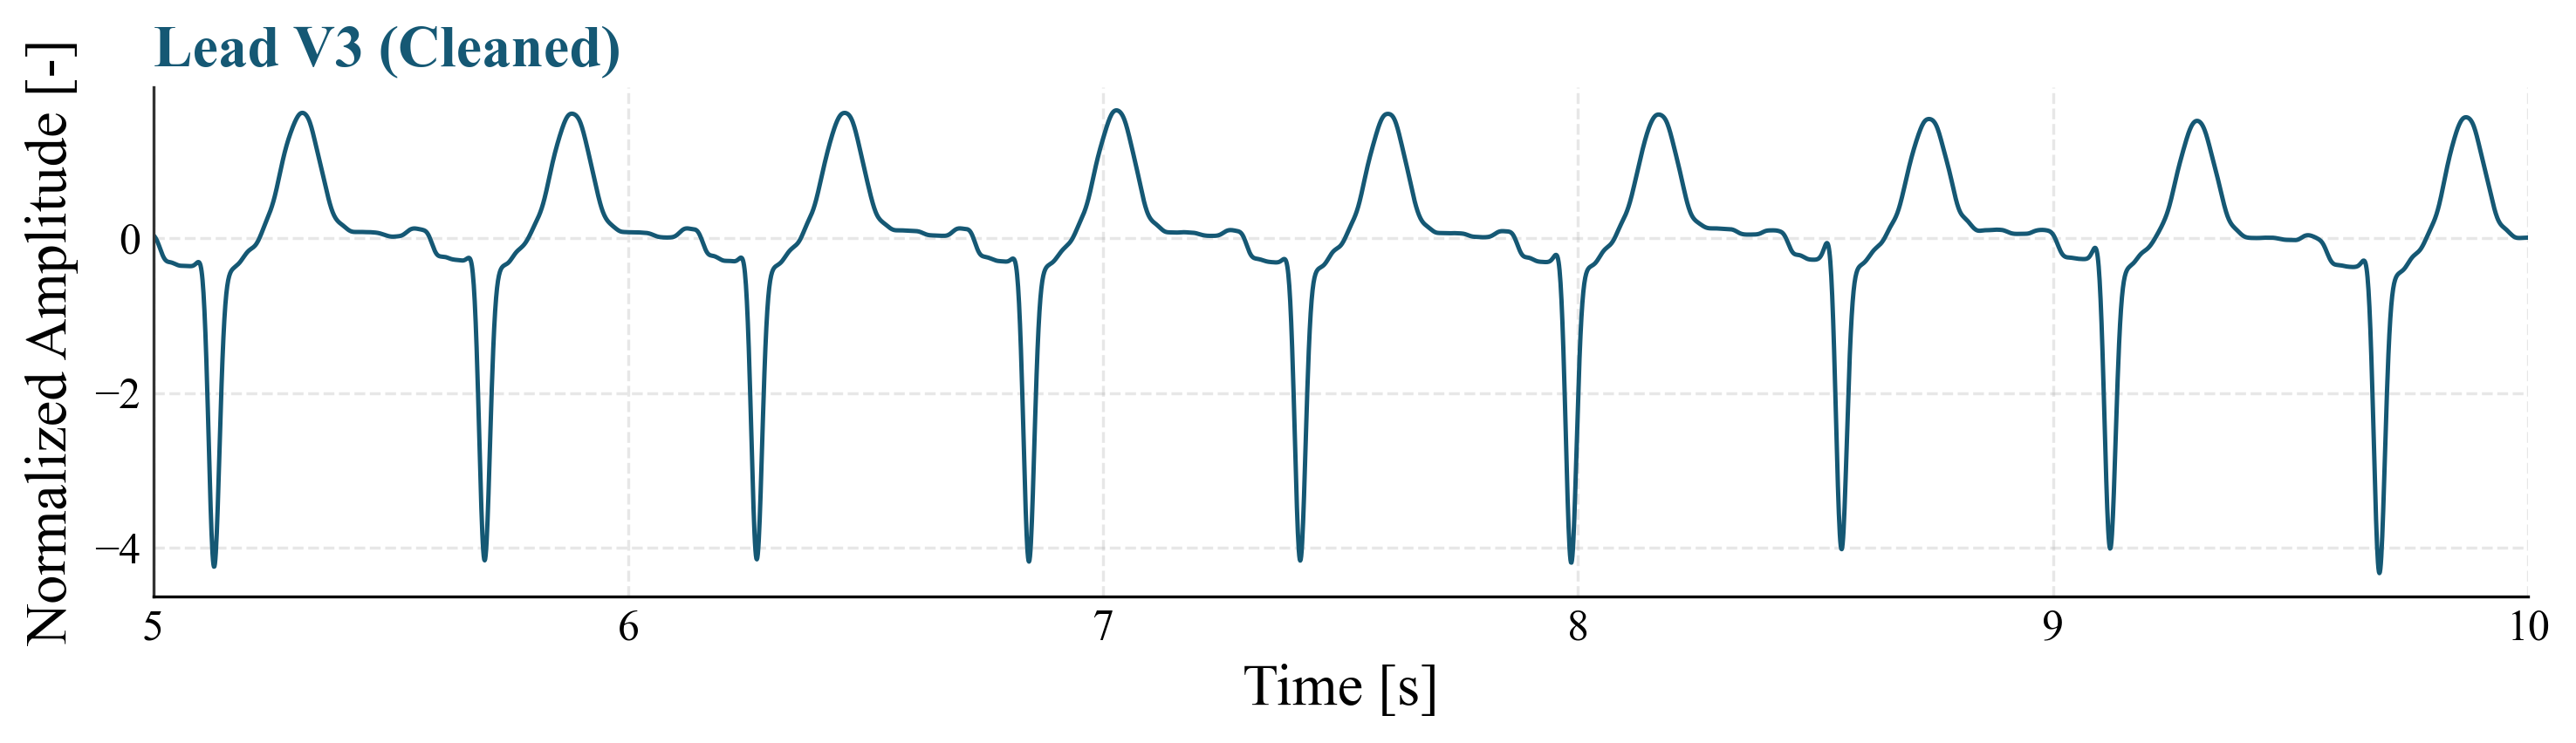

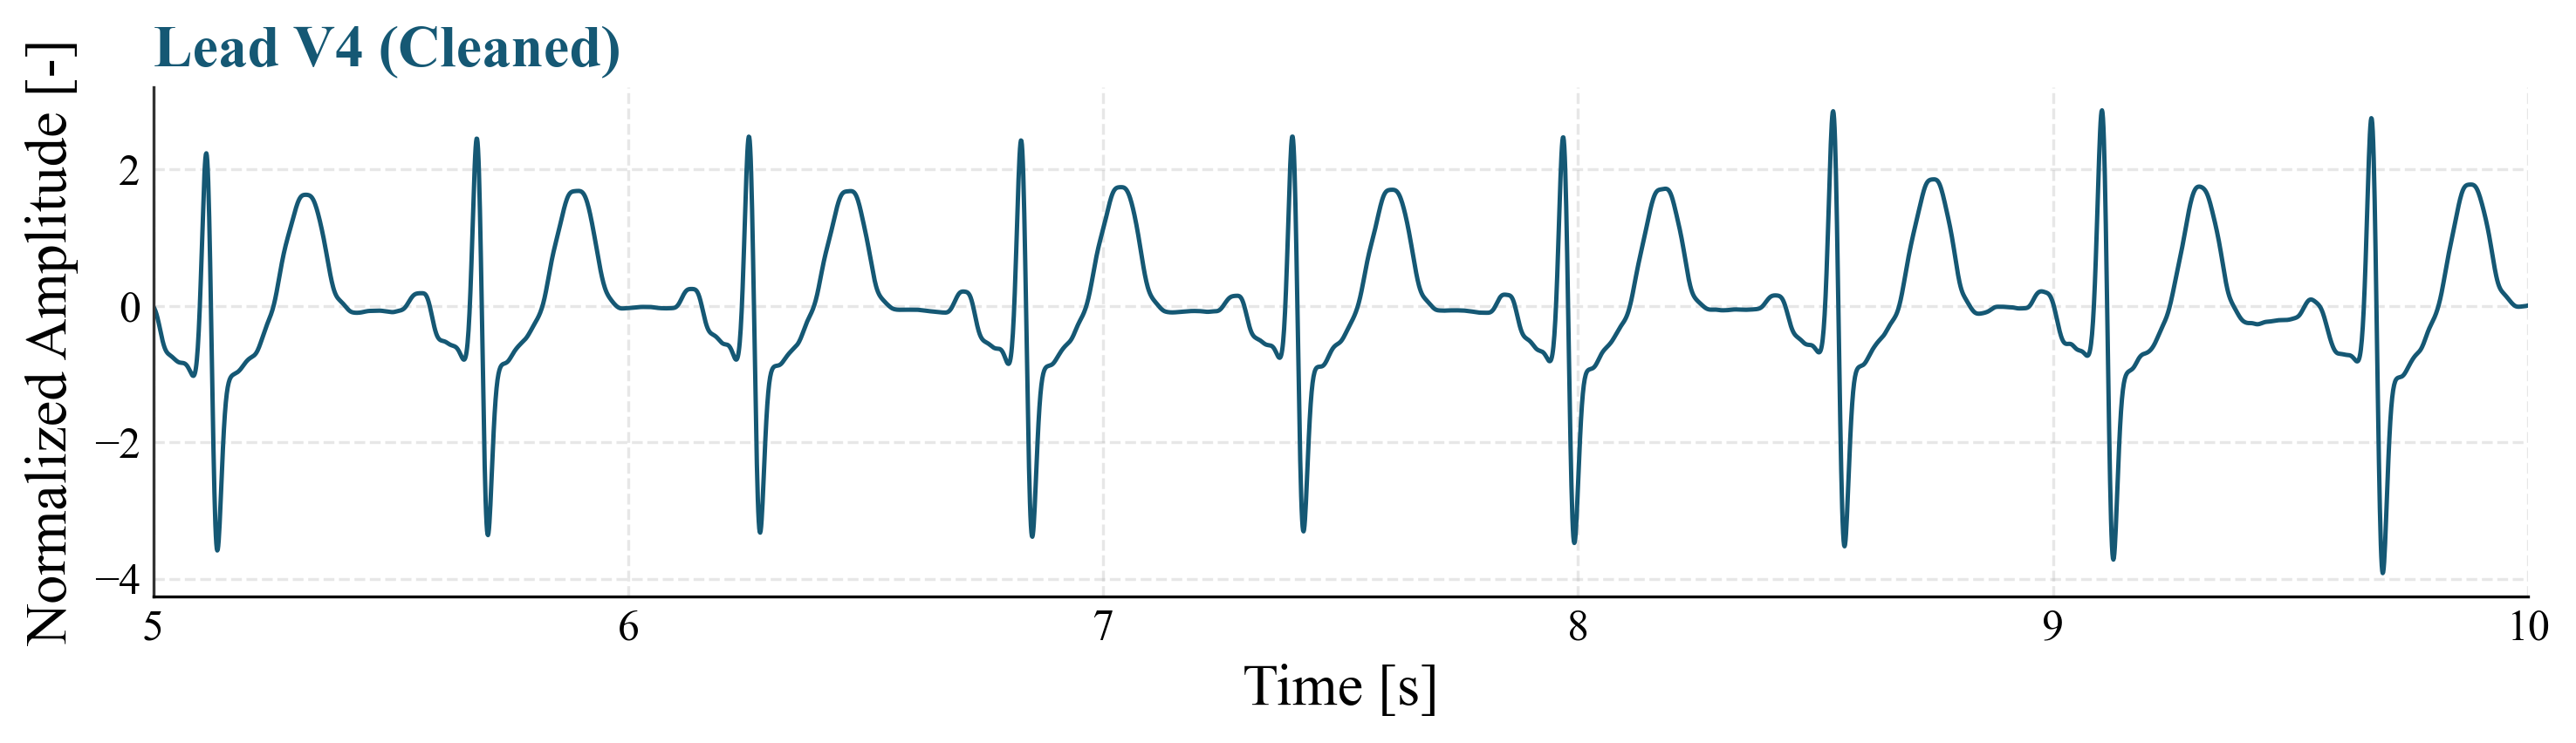

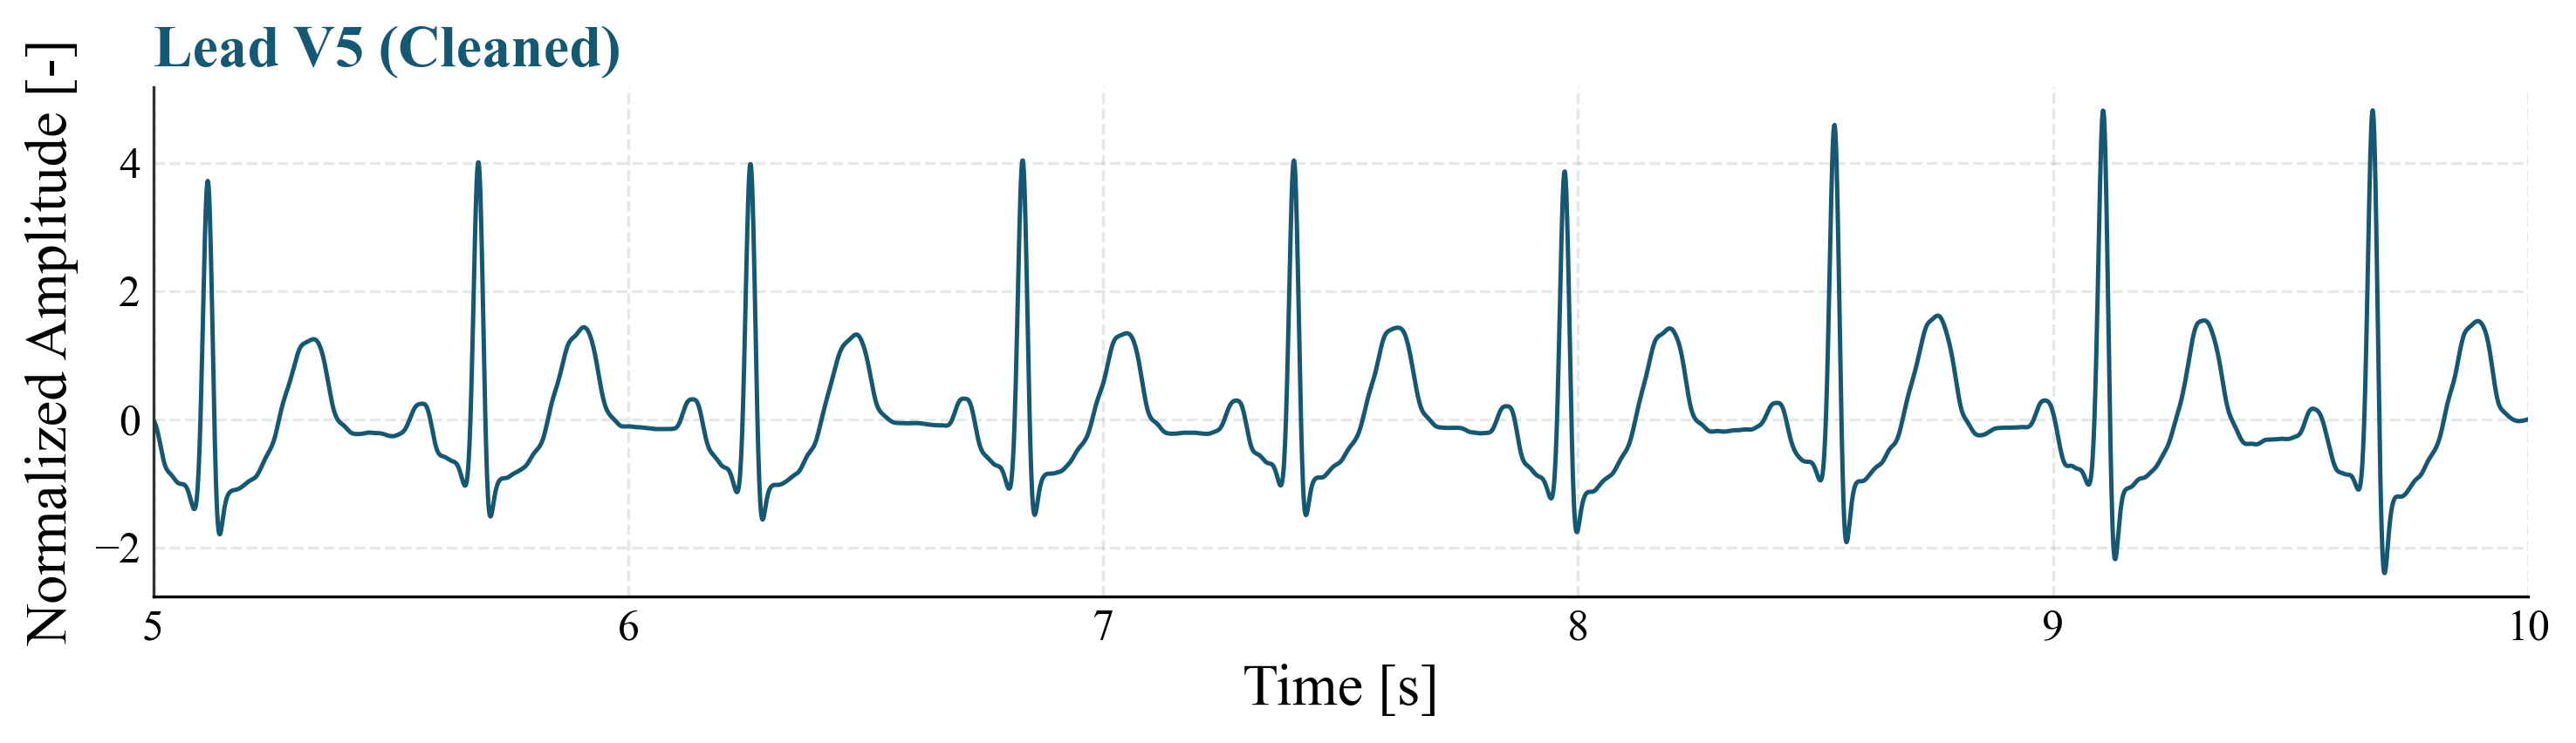

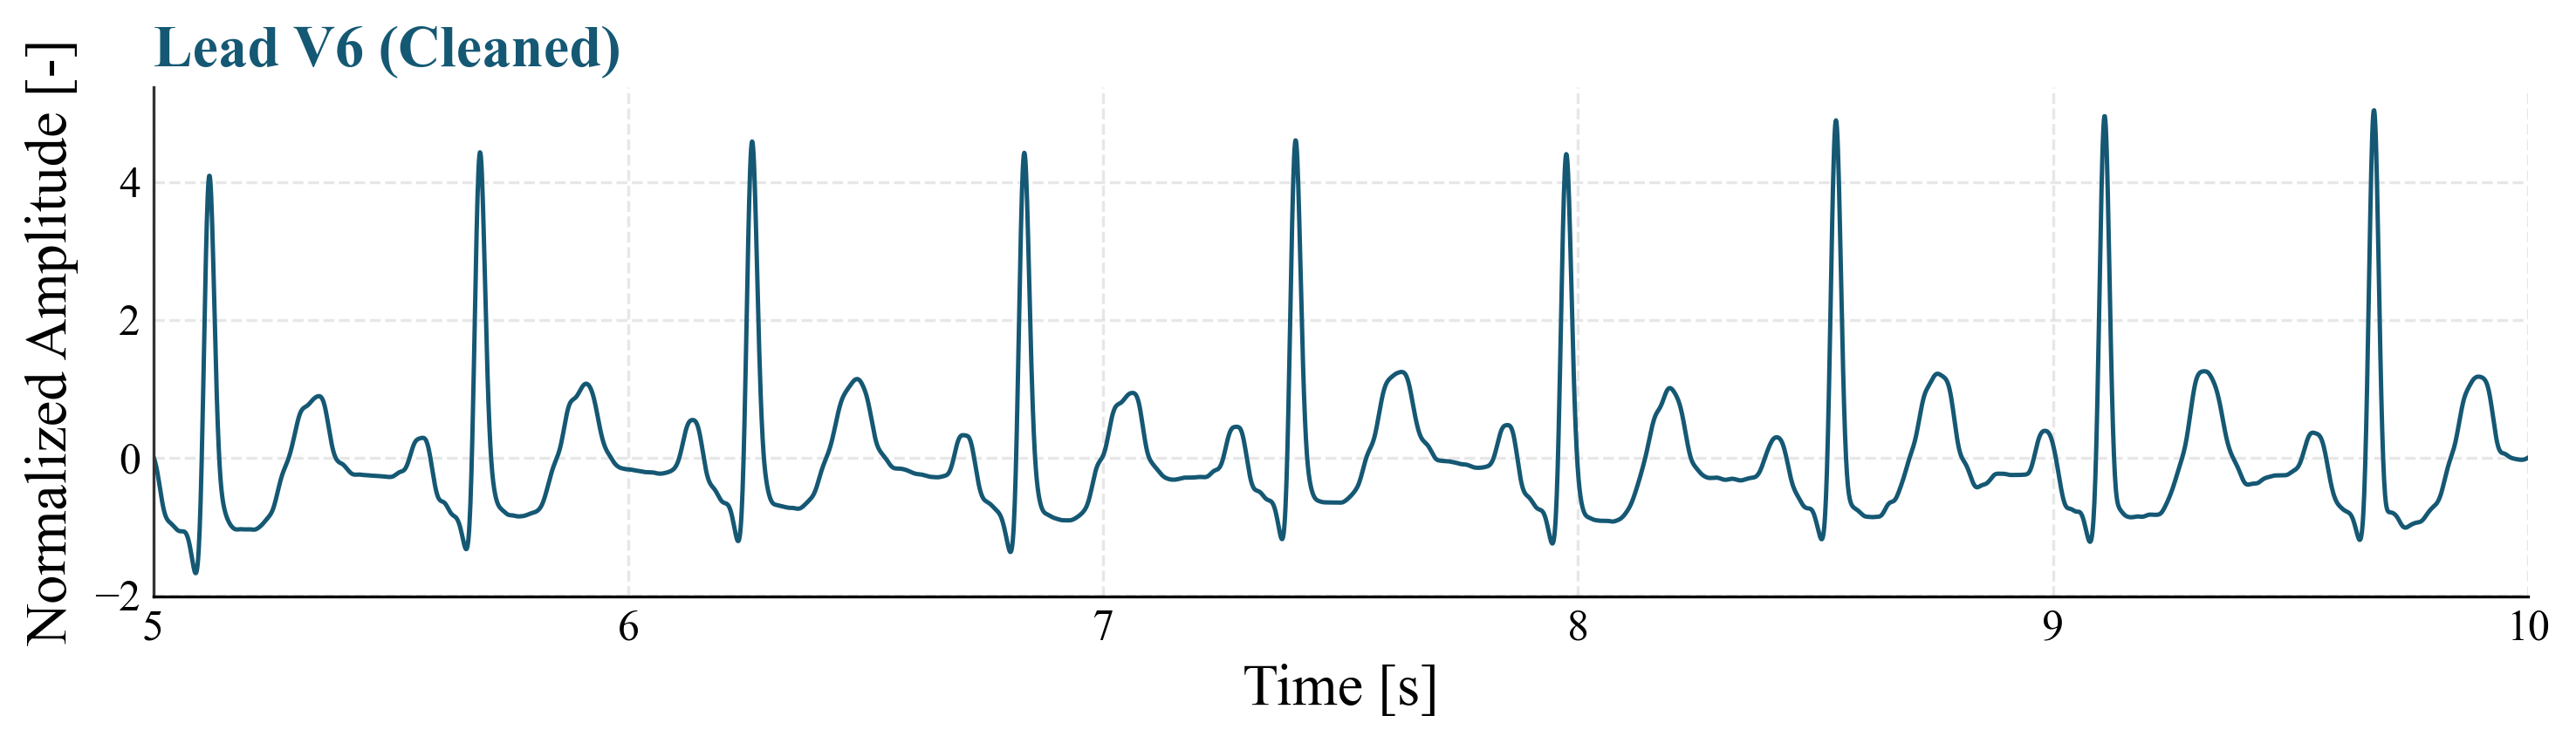

In [85]:
def _get_patient_signal(patient_id, signals, tabular_data):
    """Internal helper to safely get patient index and signal."""
    idx_list = tabular_data.index[tabular_data['ECG_patient_id'] == patient_id].tolist()
    if len(idx_list) == 0:
        raise ValueError(f"Patient id {patient_id} not found.")
    idx = int(idx_list[0])
    
    if idx < 0 or idx >= signals.shape[0]:
        raise IndexError(f"Index {idx} out of range.")
        
    return signals[idx]

def plot_raw_leads_separate(patient_id, signals_raw, tabular_data, fs=1000):
    """
    Generates 12 separate figures for the RAW ECG leads.
    No normalization is applied.
    """
    sig = _get_patient_signal(patient_id, signals_raw, tabular_data)
    t = np.arange(sig.shape[0]) / fs
    lead_names = ['I','II','III','aVR','aVL','aVF','V1','V2','V3','V4','V5','V6']

    print(f"--- RAW ECG Signals for Patient {patient_id} ---")
    
    for i, name in enumerate(lead_names):
        plt.figure(figsize=(10, 3)) # Wider, shorter aspect ratio for single lead

        ax = plt.gca()
        # Plot raw signal directly (no z-score)
        ax.plot(t if i < 6 else t + 5, sig[:, i], color='black', linewidth=1)
        
        # Turn off top, right, and bottom spines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(True)
        
        # Keep only the left spine
        ax.spines['left'].set_visible(True)
        ax.spines['left'].set_color('#333333')   # Dark grey instead of harsh black

        ax.tick_params(axis='both', labelsize=12, length=0)  # Remove tick marks for cleaner look

        ax.set_title(f"Lead {name} (Raw)", loc='left', fontweight='bold', fontsize=16)
        if i < 6:
            ax.set_xlim(0,5)  # Show only the first 5 seconds for better visibility
        else:
            ax.set_xlim(5,10)  # Show only the first 5 seconds for better visibility
        ax.set_xlabel("Time [s]", size=16)
        ax.set_ylabel("Amplitude [mV]", size=16)
        ax.grid(True, which='both', linestyle='--', alpha=0.3)
        plt.tight_layout()
        plt.show()

def plot_clean_leads_separate(patient_id, signals_clean, tabular_data, fs=1000):
    """
    Generates 12 separate figures for the CLEANED ECG leads.
    """
    sig = _get_patient_signal(patient_id, signals_clean, tabular_data)
    t = np.arange(sig.shape[0]) / fs
    lead_names = ['I','II','III','aVR','aVL','aVF','V1','V2','V3','V4','V5','V6']

    print(f"--- CLEANED ECG Signals for Patient {patient_id} ---")

    for i, name in enumerate(lead_names):
        plt.figure(figsize=(10, 3))

        ax = plt.gca()
        
        # Plot cleaned signal in your preferred blue
        ax.plot(t if i < 6 else t + 5, sig[:, i], color='#155874', linewidth=1.2)
        
        # Turn off top, right, and bottom spines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(True)
        
        # Keep only the left spine
        ax.spines['left'].set_visible(True)
        ax.spines['left'].set_color('#333333')   # Dark grey instead of harsh black

        ax.tick_params(axis='both', labelsize=12, length=0)  # Remove tick marks for cleaner look
        
        ax.set_title(f"Lead {name} (Cleaned)", loc='left', fontweight='bold', color='#155874', fontsize=16)
        if i < 6:
            ax.set_xlim(0,5)  # Show only the first 5 seconds for better visibility
        else:
            ax.set_xlim(5,10)  # Show only the first 5 seconds for better visibility
        ax.set_xlabel("Time [s]", size=16)
        ax.set_ylabel("Normalized Amplitude [-]", size=16)
        ax.grid(True, which='both', linestyle='--', alpha=0.3)
        plt.tight_layout()
        plt.show()

# --- Usage ---
plot_raw_leads_separate(4, signals, tabular_data_Batch_01)
plot_clean_leads_separate(4, signals_clean, tabular_data_Batch_01)